In [1]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 103.4 MB/s eta 0:00:0000:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [53]:
# Install once (if needed)
# !pip install torch-geometric rdkit-pypi pandas matplotlib seaborn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool as gap
from torch_geometric.data import Data, DataLoader
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import random
from rdkit.Chem import Descriptors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
import time
import math
import re
from tqdm import tqdm
import networkx as nx
import joblib
import pickle
import matplotlib.image as mpimg
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone

In [3]:
import sklearn
print(sklearn.__version__)

1.6.1


## GNN

In [4]:
# === Atom-level features ===
def atom_features(atom):
    return np.array([
        atom.GetAtomicNum(),
        atom.GetFormalCharge(),
        atom.GetDegree(),
        int(atom.GetHybridization()), 
        atom.GetTotalNumHs(),
        int(atom.GetIsAromatic()),
        int(atom.IsInRing())
    ], dtype=np.float32)

# === SMILES to Graph ===
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        Chem.Kekulize(mol, clearAromaticFlags=True)
    except:
        return None
    features = [atom_features(atom) for atom in mol.GetAtoms()]
    edges = [[], []]
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edges[0] += [start, end]
        edges[1] += [end, start]
    return Data(
        x=torch.tensor(np.array(features), dtype=torch.float),
        edge_index=torch.tensor(edges, dtype=torch.long)
    )

# === Global molecular descriptors ===
def compute_global_descriptors(smiles, exclude_mollogp=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.HeavyAtomCount(mol),
    ]
    if not exclude_mollogp:
        descriptors.append(Descriptors.MolLogP(mol))
    descriptors += [
        Descriptors.FractionCSP3(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumAromaticRings(mol)
    ]
    return descriptors

# === Molecule Grid Visualization ===
def visualize_molecules_from_csv(csv_file, num_mols=6, sep=','):
    df = pd.read_csv(csv_file, sep=sep)
    df.columns = [col.strip().lower() for col in df.columns]
    if 'smiles' not in df.columns:
        print("No SMILES column found in the dataset.")
        return
    mols = [Chem.MolFromSmiles(s) for s in df['smiles'][:num_mols] if Chem.MolFromSmiles(s)]
    if mols:
        img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))
        display(img)

# === Graph Visualization ===
def visualize_graph(data):
    G = nx.Graph()
    for i, feat in enumerate(data.x):
        G.add_node(i, label=str(int(feat[0].item())))
    edge_index = data.edge_index.numpy()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, labels=nx.get_node_attributes(G, 'label'),
            node_color='magenta', edge_color='gray', node_size=500)
    plt.title("Molecular Graph")
    plt.show()

# === Main Dataset Loader ===
def load_dataset(csv_file, targets, dataset_name="dataset", sep=',', exclude_mollogp=False):
    df = pd.read_csv(csv_file, sep=sep)
    data_list = []

    smiles_col = 'smiles' if 'smiles' in df.columns else 'SMILES' if 'SMILES' in df.columns else None
    if smiles_col is None:
        print("No SMILES column found in the dataset.")
        return []

    raw_descriptors = []
    smiles_list = []

    for _, row in df.iterrows():
        smiles = row[smiles_col]
        desc = compute_global_descriptors(smiles, exclude_mollogp=exclude_mollogp)
        if desc is not None:
            raw_descriptors.append(desc)
            smiles_list.append((smiles, row))

    if not raw_descriptors:
        print("No valid molecules found for descriptor extraction.")
        return []

    # === Normalize global descriptors ===
    scaler = StandardScaler()
    raw_descriptors = np.array(raw_descriptors)
    scaled_descriptors = scaler.fit_transform(raw_descriptors)

    # Save scaler for backend use
    joblib.dump(scaler, f"{dataset_name}_gnn_scaler.pkl")

    # Save SMILES to index mapping
    smiles_to_index = {smi: i for i, (smi, _) in enumerate(smiles_list)}
    with open(f"{dataset_name}_gnn_smiles_map.pkl", "wb") as f:
        pickle.dump(smiles_to_index, f)

    # === Build graph data list ===
    for i, (smiles, row) in enumerate(smiles_list):
        graph = mol_to_graph(smiles)
        if graph is None:
            continue
        try:
            if isinstance(targets, list):
                graph.y = torch.tensor(row[targets].astype(float).values, dtype=torch.float)
            else:
                graph.y = torch.tensor([float(row[targets])], dtype=torch.float)

            graph.global_x = torch.tensor(scaled_descriptors[i], dtype=torch.float)
            data_list.append(graph)
        except Exception as e:
            continue

    return data_list, scaler, smiles_to_index

In [5]:
class modelGcn(nn.Module):
    def __init__(self, num_features=7, output_dim=1, dropout=0.2, global_dim=10):
        super(modelGcn, self).__init__()

        # MLPs for GIN layers
        self.mlp1 = nn.Sequential(
            nn.Linear(num_features, num_features),
            nn.ReLU(),
            nn.Linear(num_features, num_features)
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(num_features, num_features * 2),
            nn.ReLU(),
            nn.Linear(num_features * 2, num_features * 2)
        )
        self.mlp3 = nn.Sequential(
            nn.Linear(num_features * 2, num_features * 2),
            nn.ReLU(),
            nn.Linear(num_features * 2, num_features * 2)
        )

        # GINConv layers
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.conv3 = GINConv(self.mlp3)

        # BatchNorm layers
        self.bn1 = nn.BatchNorm1d(num_features)
        self.bn2 = nn.BatchNorm1d(num_features * 2)
        self.bn3 = nn.BatchNorm1d(num_features * 2)

        self.dropout = nn.Dropout(dropout)

        # Deep fusion MLP (GCN + global descriptors)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(num_features * 2 + global_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x, edge_index, batch, global_x):
        x = self.bn1(F.relu(self.conv1(x, edge_index)))
        x = self.bn2(F.relu(self.conv2(x, edge_index)))
        x = self.bn3(F.relu(self.conv3(x, edge_index)))
        x = gap(x, batch)
        x = self.dropout(x)

        if global_x.dim() == 1 or global_x.shape[0] != x.shape[0]:
            global_x = global_x.view(x.size(0), -1)

        # Save intermediate features for later extraction
        fused = torch.cat([x, global_x], dim=1)
        self.last_features = fused.detach()  # for evaluation
        return self.fusion_mlp(fused)

In [6]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, target_names,
          max_epochs=100, patience=10, dataset_name="dataset", save_dir="."):
    best_val_loss = float('inf')
    best_model_state = None
    best_val_preds = None
    best_val_trues = None
    patience_counter = 0

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            global_feats = torch.stack([d.global_x for d in data.to_data_list()]).to(device)
            output = model(data.x, data.edge_index, data.batch, global_feats)
            loss = criterion(output, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        train_loss = total_loss / len(train_loader.dataset)

        # Validation
        preds, trues = evaluate(model, val_loader, device, target_names)
        val_loss = mean_squared_error(trues, preds)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_val_preds = preds
            best_val_trues = trues
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Save best model
    model_path = os.path.join(save_dir, f"{dataset_name}_gcn_model.pth")
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved to {model_path}")

    # Save best predictions
    if best_val_preds is not None and best_val_trues is not None:
        df_val = pd.DataFrame({
            "Actual": best_val_trues.flatten(),
            "Predicted": best_val_preds.flatten(),
            "Residual": (best_val_trues - best_val_preds).flatten()
        })
        pred_path = os.path.join(save_dir, f"{dataset_name}_val_predictions.csv")
        df_val.to_csv(pred_path, index=False)
        print(f"Saved best validation predictions to {pred_path}")

    return model


def evaluate(model, loader, device, target_names, return_features=False):
    model.eval()
    preds, trues = [], []
    all_features = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            global_feats = torch.stack([d.global_x for d in data.to_data_list()]).to(device)
            output = model(data.x, data.edge_index, data.batch, global_feats)
            preds.append(output.cpu().numpy())
            trues.append(data.y.view(-1, 1).cpu().numpy())
            if return_features:
                all_features.append(model.last_features.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    if return_features:
        return preds, trues, np.concatenate(all_features)
    return preds, trues


def print_metrics(preds, trues, target_names):
    for i, name in enumerate(target_names):
        mse = mean_squared_error(trues[:, i], preds[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(trues[:, i], preds[:, i])
        r2 = r2_score(trues[:, i], preds[:, i])
        corr, _ = pearsonr(trues[:, i], preds[:, i])
        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f} | MSE: {mse:.4f}")
        print(f"  MAE : {mae:.4f} | R² : {r2:.4f}")
        print(f"  Pearson Correlation: {corr:.4f}")

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def run_pipeline(csv_file, targets, dataset_name, sep=',', exclude_mollogp=False, save_dir="."):
    set_seed(42)
    print(f"\nRunning pipeline for: {dataset_name}")

    # Determine if MolLogP should be excluded
    exclude_logp = any(col.lower() in ['logp', 'expt'] for col in targets)

    # Visualize example molecules
    visualize_molecules_from_csv(csv_file, sep=sep)

    # Load and process dataset
    data, scaler, _ = load_dataset(
        csv_file, targets, dataset_name=dataset_name, sep=sep, exclude_mollogp=exclude_logp
    )
    if len(data) == 0:
        print("No valid molecular graphs found. Exiting.")
        return

    # Save the fitted scaler
    os.makedirs(save_dir, exist_ok=True)
    scaler_path = os.path.join(save_dir, f"{dataset_name}_descriptor_scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved to: {scaler_path}")

    global_dim = len(data[0].global_x)

    # Visualize 4 random molecular graphs
    print(f"Visualizing molecular graphs from {dataset_name}")
    df = pd.read_csv(csv_file, sep=sep)
    smiles_col = 'smiles' if 'smiles' in df.columns else 'SMILES'
    sampled_indices = random.sample(range(len(data)), min(4, len(data)))
    for i, idx in enumerate(sampled_indices):
        smi = df[smiles_col].iloc[idx]
        print(f"\nGraph {i+1} (SMILES): {smi}")
        visualize_graph(data[idx])

    # Dataset split
    train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
    loaders = {
        'train': DataLoader(train_data, batch_size=32, shuffle=True),
        'val': DataLoader(val_data, batch_size=32),
        'test': DataLoader(test_data, batch_size=32),
        'full': DataLoader(data, batch_size=32, shuffle=False)
    }

    # Setup model and training tools
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = modelGcn(output_dim=len(targets), global_dim=global_dim, num_features=7).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Correlation matrix
    features = [sample.global_x.cpu().numpy() for sample in data]
    targets_vals = [sample.y.cpu().numpy() for sample in data]
    descriptor_names = [
        "MolWt", "TPSA", "RotatableBonds", "HDonors", "Rings", "HeavyAtoms",
        "MolLogP", "FractionCSP3", "HAcceptors", "AromaticRings"
    ]
    if exclude_logp:
        descriptor_names.remove("MolLogP")

    df_all = pd.concat([
        pd.DataFrame(features, columns=descriptor_names),
        pd.DataFrame(targets_vals, columns=targets)
    ], axis=1)
    corr_matrix = df_all.corr().round(3)
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # Train model
    model = train(model, loaders['train'], loaders['val'], optimizer, scheduler, criterion,
                  device, targets, dataset_name=dataset_name, save_dir=save_dir)

    # Evaluate on test set
    test_preds, test_trues, test_features = evaluate(model, loaders['test'], device, targets, return_features=True)
    print_metrics(test_preds, test_trues, targets)

    # Save predictions
    df_test = pd.DataFrame({
        "Actual": test_trues.flatten(),
        "Predicted": test_preds.flatten(),
        "Residual": (test_trues - test_preds).flatten()
    })
    test_csv_path = os.path.join(save_dir, f"{dataset_name}_test_predictions.csv")
    df_test.to_csv(test_csv_path, index=False)
    print(f"Saved test predictions to: {test_csv_path}")

    # Save GCN features
    print("Extracting GCN features from full dataset...")
    _, all_trues, all_features = evaluate(model, loaders['full'], device, targets, return_features=True)
    np.save(os.path.join(save_dir, f"gcn_features_{dataset_name}.npy"), all_features)
    np.save(os.path.join(save_dir, f"gcn_targets_{dataset_name}.npy"), all_trues)

    # Also save CSV
    feature_columns = [f"feature_{i}" for i in range(all_features.shape[1])]
    df_feats = pd.DataFrame(all_features, columns=feature_columns)
    for i, target in enumerate(targets):
        df_feats[target] = all_trues[:, i]
    feats_csv = os.path.join(save_dir, f"gcn_features_and_targets_{dataset_name}.csv")
    df_feats.to_csv(feats_csv, index=False)
    print(f"Saved full GCN feature CSV to: {feats_csv}")

    # Plot true vs predicted
    for i, name in enumerate(targets):
        plt.figure(figsize=(6, 5))
        plt.scatter(test_trues[:, i], test_preds[:, i], alpha=0.6, color='green', edgecolors='k')
        plt.plot([test_trues[:, i].min(), test_trues[:, i].max()],
                 [test_trues[:, i].min(), test_trues[:, i].max()], 'r--')
        plt.xlabel(f"True {name}")
        plt.ylabel(f"Predicted {name}")
        plt.title(f"{dataset_name} - {name}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Running pipeline for: Delaney


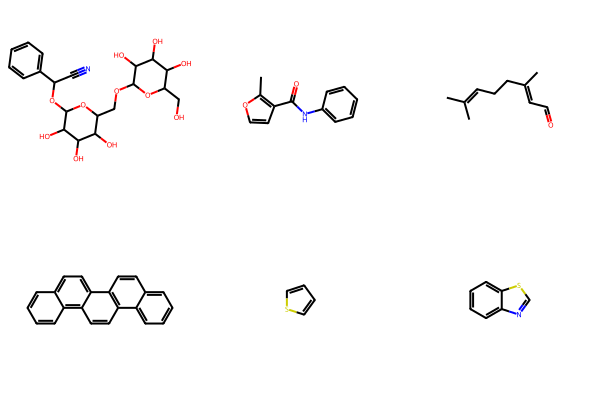

Scaler saved to: /kaggle/working/Delaney_descriptor_scaler.pkl
Visualizing molecular graphs from Delaney

Graph 1 (SMILES): CC(C)=CCCC(O)(C)C=C


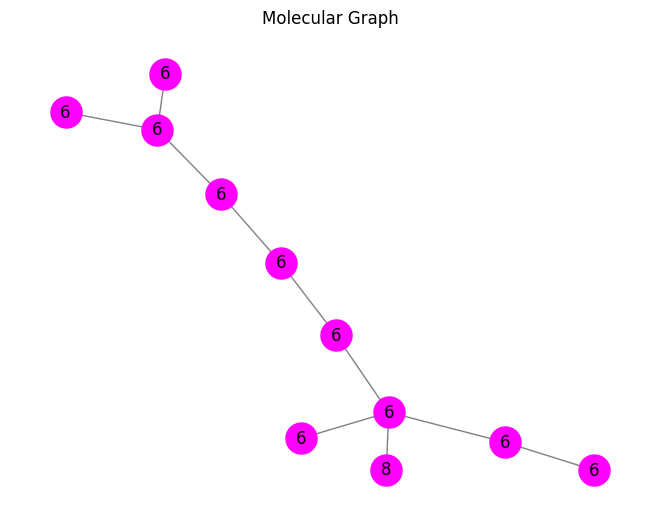


Graph 2 (SMILES): CCC1(C(=O)NC(=O)NC1=O)C2=CCCCC2 


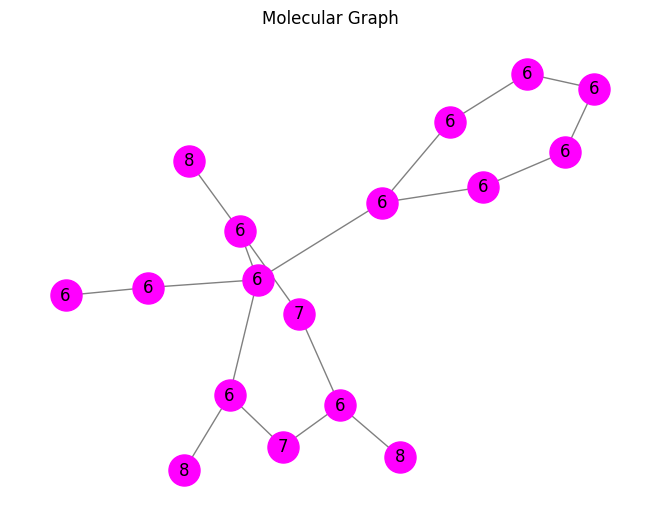


Graph 3 (SMILES): COC(=O)c1ccccc1C(=O)OC


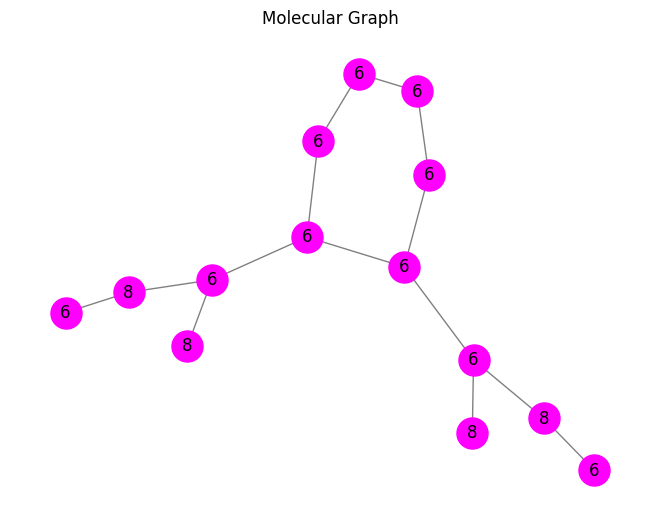


Graph 4 (SMILES): Brc1ccc(Br)cc1


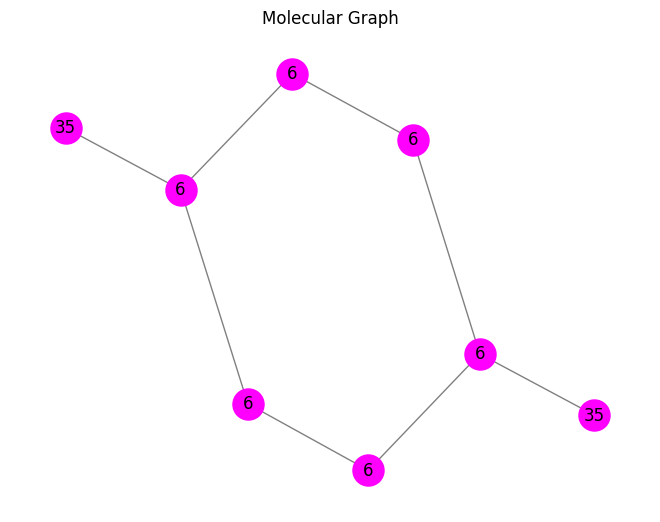

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Correlation Matrix:
                                           MolWt   TPSA  RotatableBonds  \
MolWt                                      1.000  0.475           0.397   
TPSA                                       0.475  1.000           0.287   
RotatableBonds                             0.397  0.287           1.000   
HDonors                                    0.255  0.756           0.077   
Rings                                      0.653  0.309          -0.137   
HeavyAtoms                                 0.922  0.576           0.425   
MolLogP                                    0.477 -0.445           0.214   
FractionCSP3                              -0.152 -0.055           0.316   
HAcceptors                                 0.555  0.897           0.425   
AromaticRings                              0.344  0.045          -0.119   
measured log solubility in mols per litre -0.640  0.123          -0.244   

                                           HDonors  Rings  HeavyAtoms  \
MolWt

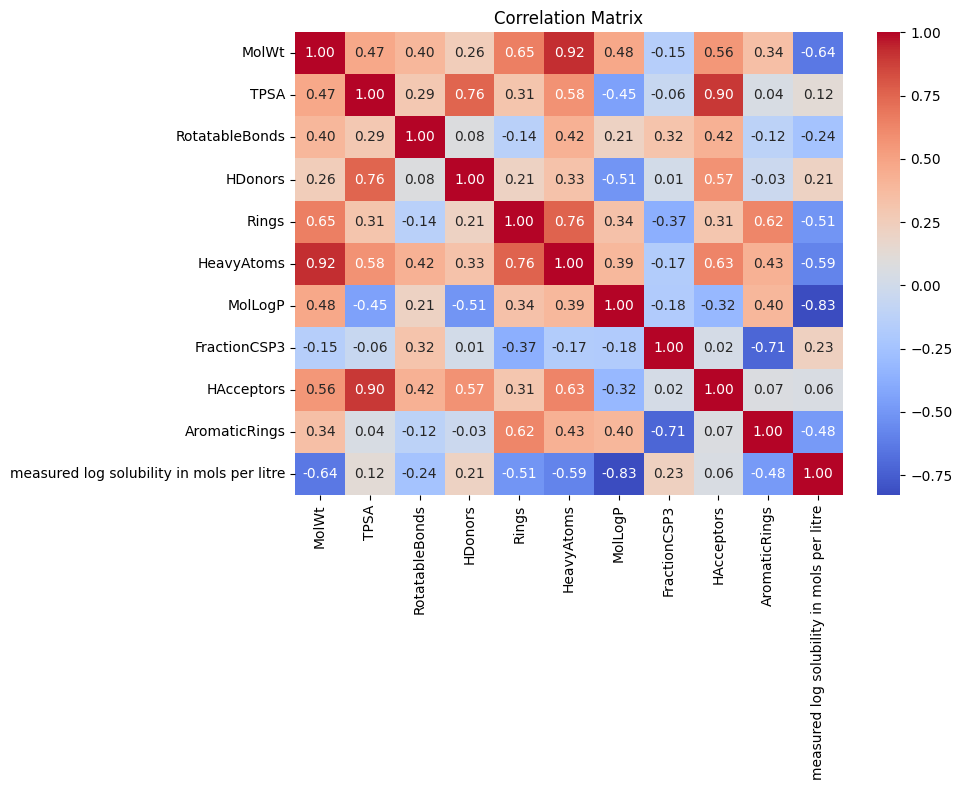

Epoch 001 | Train Loss: 8.8140 | Val Loss: 5.7334
Epoch 002 | Train Loss: 2.7193 | Val Loss: 1.5642
Epoch 003 | Train Loss: 1.4295 | Val Loss: 1.2166
Epoch 004 | Train Loss: 1.2273 | Val Loss: 1.2031
Epoch 005 | Train Loss: 1.2286 | Val Loss: 1.0028
Epoch 006 | Train Loss: 1.2087 | Val Loss: 0.9813
Epoch 007 | Train Loss: 1.0287 | Val Loss: 0.8617
Epoch 008 | Train Loss: 0.9820 | Val Loss: 0.8471
Epoch 009 | Train Loss: 0.9907 | Val Loss: 0.7200
Epoch 010 | Train Loss: 0.9478 | Val Loss: 0.7942
Epoch 011 | Train Loss: 0.8407 | Val Loss: 0.7605
Epoch 012 | Train Loss: 0.7859 | Val Loss: 0.7663
Epoch 013 | Train Loss: 0.8517 | Val Loss: 0.7028
Epoch 014 | Train Loss: 0.8468 | Val Loss: 0.6535
Epoch 015 | Train Loss: 0.7287 | Val Loss: 0.7210
Epoch 016 | Train Loss: 0.7727 | Val Loss: 0.6477
Epoch 017 | Train Loss: 0.7906 | Val Loss: 0.6075
Epoch 018 | Train Loss: 0.7439 | Val Loss: 0.6360
Epoch 019 | Train Loss: 0.7216 | Val Loss: 0.7422
Epoch 020 | Train Loss: 0.7345 | Val Loss: 0.7369


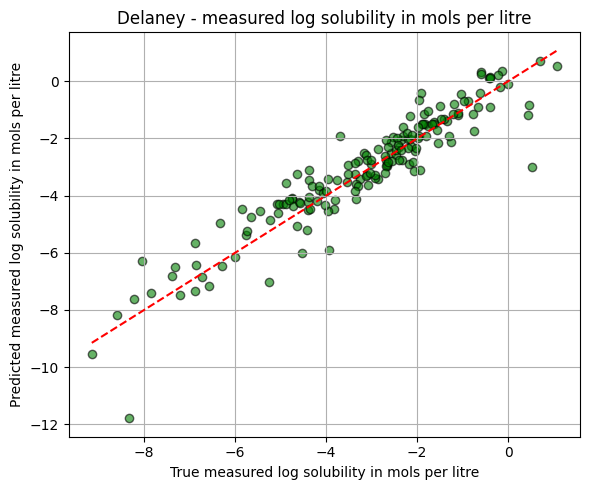


Running pipeline for: logD74


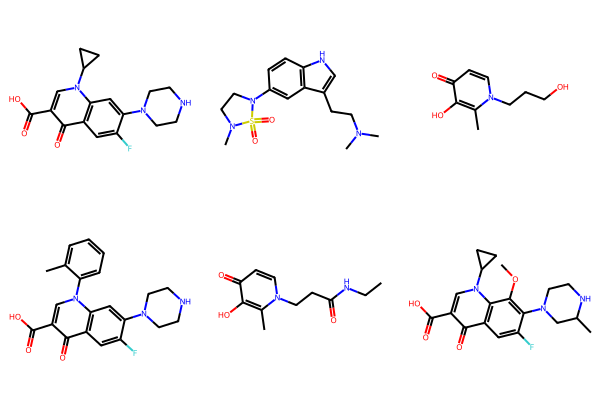

Scaler saved to: /kaggle/working/logD74_descriptor_scaler.pkl
Visualizing molecular graphs from logD74

Graph 1 (SMILES): Clc1sc2S(=O)(=O)N=C(Nc2c1)NC(C)C


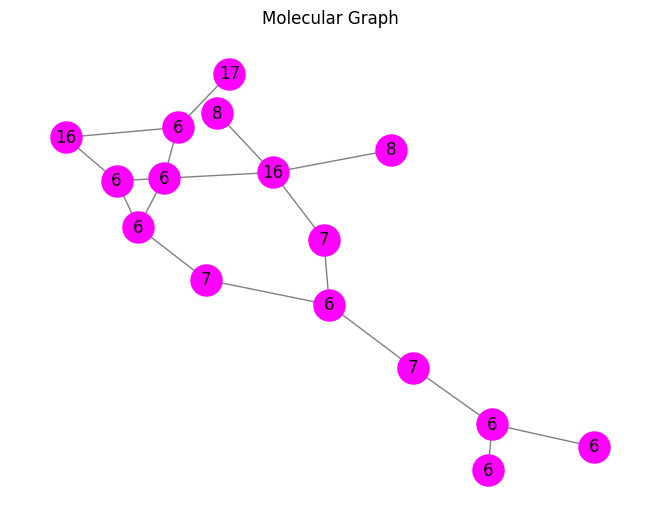


Graph 2 (SMILES): n12C=CC=Nc1ncc2


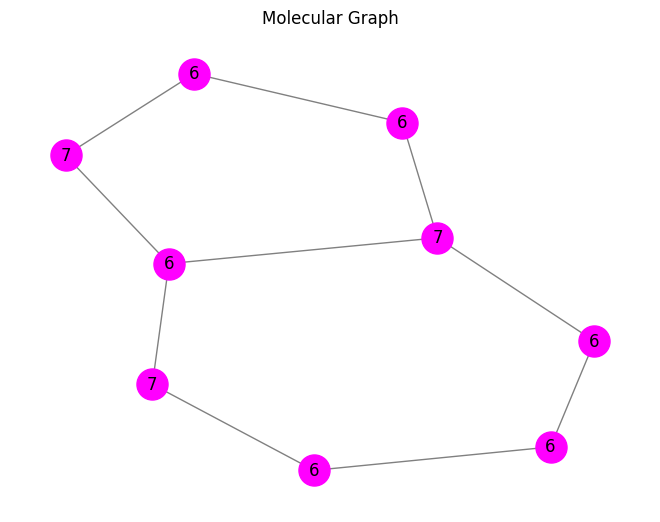


Graph 3 (SMILES): O(C(=O)[C@H]1CC2N(C(CC2)[C@H]1C(OC)=O)C)c1ccccc1


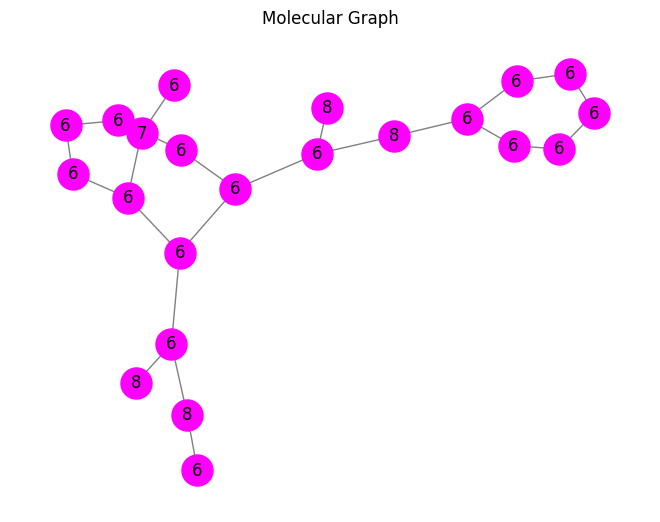


Graph 4 (SMILES): n1-2c(ccc1)C(=Nc1c-2cccc1)CCCCC


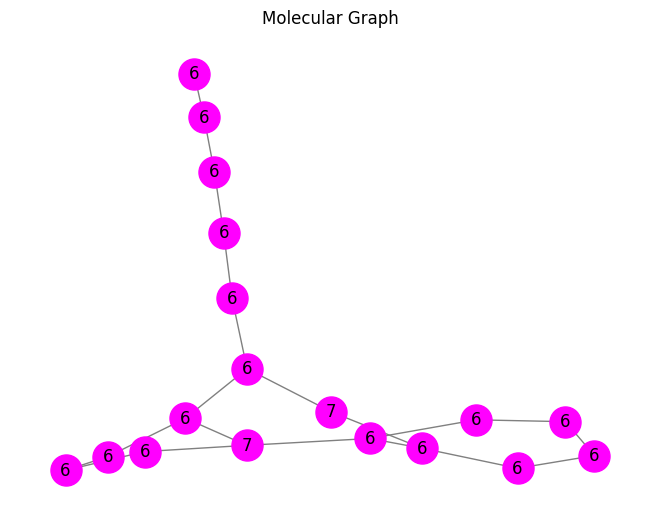


Correlation Matrix:
                MolWt   TPSA  RotatableBonds  HDonors  Rings  HeavyAtoms  \
MolWt           1.000  0.640           0.762    0.441  0.605       0.973   
TPSA            0.640  1.000           0.569    0.809  0.192       0.664   
RotatableBonds  0.762  0.569           1.000    0.528  0.178       0.760   
HDonors         0.441  0.809           0.528    1.000  0.015       0.471   
Rings           0.605  0.192           0.178    0.015  1.000       0.645   
HeavyAtoms      0.973  0.664           0.760    0.471  0.645       1.000   
MolLogP         0.473 -0.187           0.350   -0.181  0.491       0.474   
FractionCSP3    0.360  0.231           0.433    0.230  0.024       0.333   
HAcceptors      0.714  0.797           0.612    0.510  0.375       0.719   
AromaticRings   0.301  0.078           0.162   -0.002  0.583       0.347   
logD7.4         0.336 -0.169           0.270   -0.210  0.351       0.329   

                MolLogP  FractionCSP3  HAcceptors  AromaticRings  

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


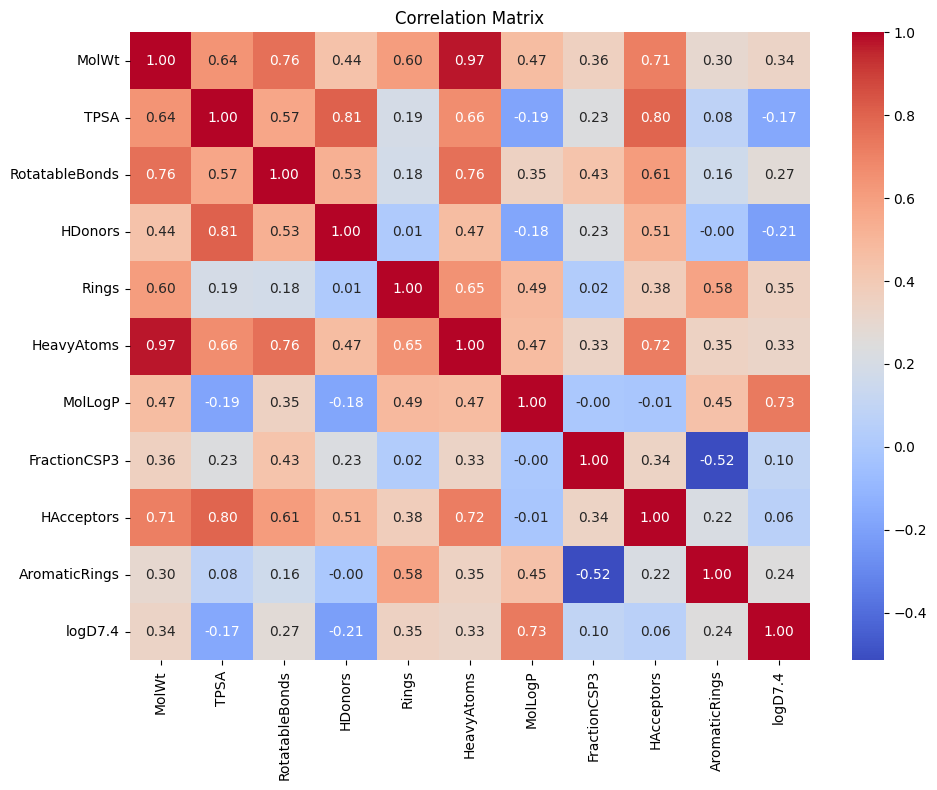

Epoch 001 | Train Loss: 4.8021 | Val Loss: 3.1539
Epoch 002 | Train Loss: 2.2622 | Val Loss: 1.8176
Epoch 003 | Train Loss: 1.5867 | Val Loss: 2.3195
Epoch 004 | Train Loss: 1.4159 | Val Loss: 1.4800
Epoch 005 | Train Loss: 1.2667 | Val Loss: 1.4938
Epoch 006 | Train Loss: 1.2749 | Val Loss: 1.4992
Epoch 007 | Train Loss: 1.1885 | Val Loss: 1.8643
Epoch 008 | Train Loss: 1.1559 | Val Loss: 1.3758
Epoch 009 | Train Loss: 1.1854 | Val Loss: 1.5550
Epoch 010 | Train Loss: 1.1290 | Val Loss: 1.2156
Epoch 011 | Train Loss: 1.0857 | Val Loss: 1.0266
Epoch 012 | Train Loss: 1.0548 | Val Loss: 1.5762
Epoch 013 | Train Loss: 1.0438 | Val Loss: 1.3531
Epoch 014 | Train Loss: 1.0489 | Val Loss: 1.0723
Epoch 015 | Train Loss: 1.0232 | Val Loss: 0.9919
Epoch 016 | Train Loss: 0.9883 | Val Loss: 1.0556
Epoch 017 | Train Loss: 0.9553 | Val Loss: 1.1006
Epoch 018 | Train Loss: 0.9893 | Val Loss: 0.9528
Epoch 019 | Train Loss: 0.9283 | Val Loss: 0.9460
Epoch 020 | Train Loss: 0.8746 | Val Loss: 0.9134


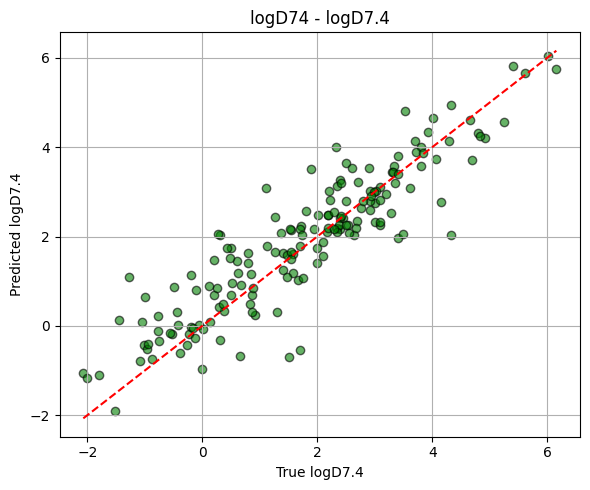


Running pipeline for: SAMPL


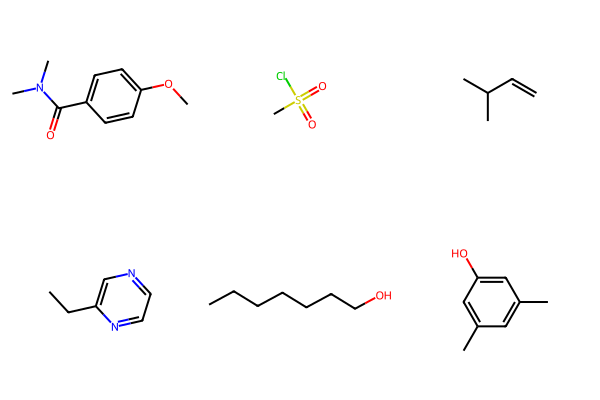

Scaler saved to: /kaggle/working/SAMPL_descriptor_scaler.pkl
Visualizing molecular graphs from SAMPL

Graph 1 (SMILES): c1ccc(cc1)CBr


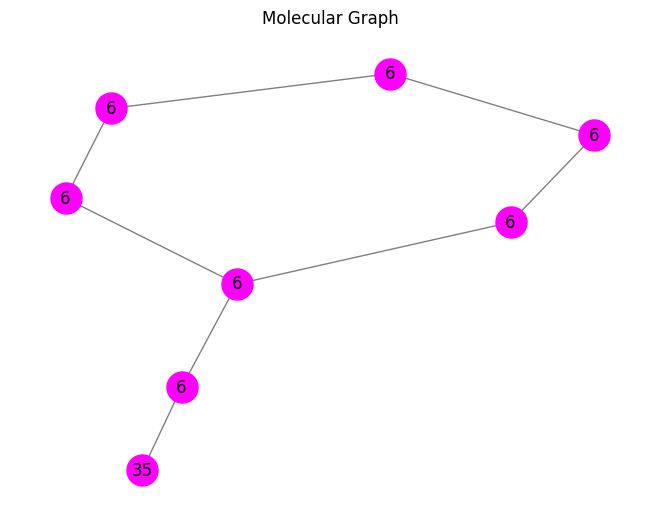


Graph 2 (SMILES): CCCCC#N


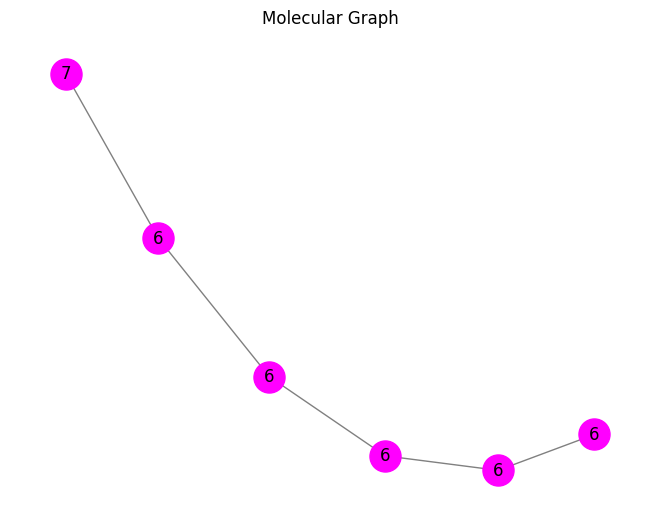


Graph 3 (SMILES): CC#C


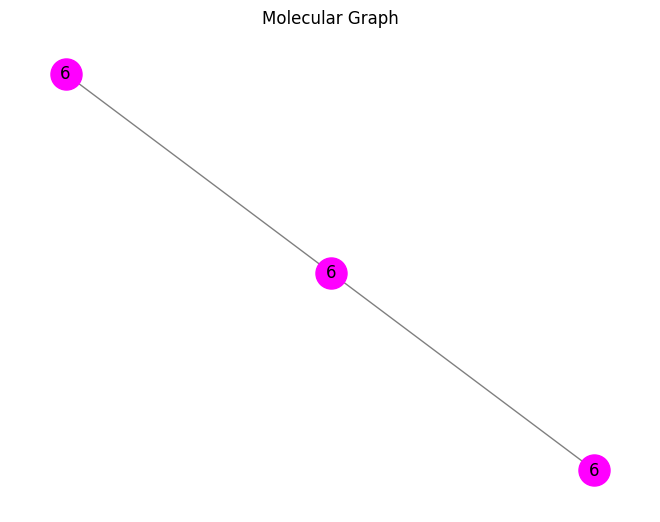


Graph 4 (SMILES): CCCC(=O)OCC


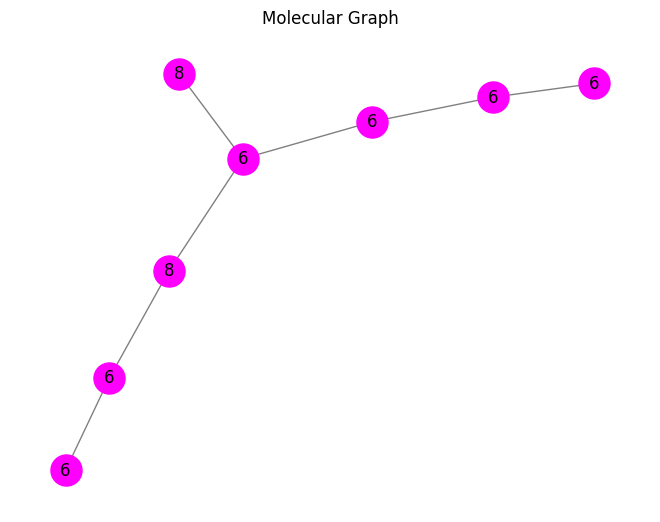


Correlation Matrix:
                MolWt   TPSA  RotatableBonds  HDonors  Rings  HeavyAtoms  \
MolWt           1.000  0.260           0.278   -0.016  0.574       0.882   
TPSA            0.260  1.000           0.315    0.513  0.087       0.413   
RotatableBonds  0.278  0.315           1.000   -0.046 -0.278       0.357   
HDonors        -0.016  0.513          -0.046    1.000  0.083       0.072   
Rings           0.574  0.087          -0.278    0.083  1.000       0.688   
HeavyAtoms      0.882  0.413           0.357    0.072  0.688       1.000   
FractionCSP3   -0.298 -0.095           0.325   -0.092 -0.654      -0.410   
HAcceptors      0.367  0.870           0.460    0.292  0.087       0.489   
AromaticRings   0.505  0.103          -0.204    0.096  0.848       0.644   
expt           -0.235 -0.736          -0.006   -0.690 -0.310      -0.350   

                FractionCSP3  HAcceptors  AromaticRings   expt  
MolWt                 -0.298       0.367          0.505 -0.235  
TPSA        

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


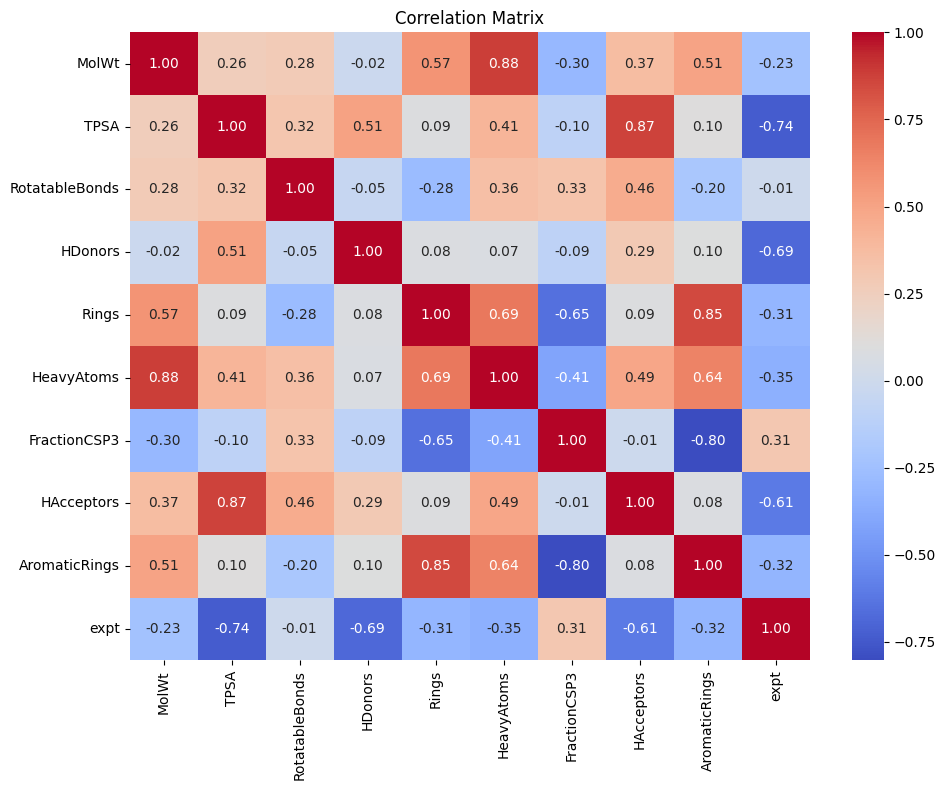

Epoch 001 | Train Loss: 24.9797 | Val Loss: 28.2512
Epoch 002 | Train Loss: 15.8385 | Val Loss: 16.1499
Epoch 003 | Train Loss: 8.9438 | Val Loss: 9.2939
Epoch 004 | Train Loss: 6.6629 | Val Loss: 6.9849
Epoch 005 | Train Loss: 5.9191 | Val Loss: 6.2852
Epoch 006 | Train Loss: 5.0366 | Val Loss: 5.4904
Epoch 007 | Train Loss: 4.7244 | Val Loss: 4.8607
Epoch 008 | Train Loss: 4.3613 | Val Loss: 4.8348
Epoch 009 | Train Loss: 4.3649 | Val Loss: 4.0900
Epoch 010 | Train Loss: 4.2140 | Val Loss: 4.0612
Epoch 011 | Train Loss: 4.1810 | Val Loss: 4.0220
Epoch 012 | Train Loss: 4.2059 | Val Loss: 3.6763
Epoch 013 | Train Loss: 3.7200 | Val Loss: 3.6584
Epoch 014 | Train Loss: 3.8584 | Val Loss: 3.2565
Epoch 015 | Train Loss: 3.3246 | Val Loss: 3.3065
Epoch 016 | Train Loss: 3.6882 | Val Loss: 3.2817
Epoch 017 | Train Loss: 3.2112 | Val Loss: 3.1831
Epoch 018 | Train Loss: 3.3329 | Val Loss: 3.1923
Epoch 019 | Train Loss: 3.1663 | Val Loss: 2.9949
Epoch 020 | Train Loss: 3.1631 | Val Loss: 3.0

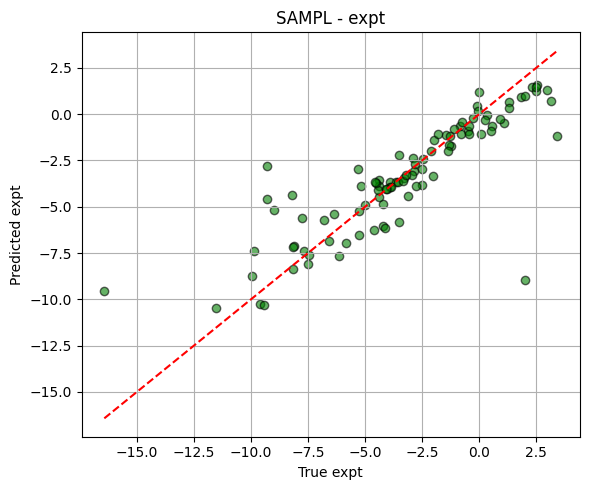

In [12]:
# Delaney: predicting logS (log solubility)
run_pipeline(
    csv_file="/kaggle/input/drugdiscoverydatasets/delaney.csv",
    targets=['measured log solubility in mols per litre'],
    dataset_name="Delaney",
    save_dir="/kaggle/working"
)

# logD74: predicting logD
run_pipeline(
    csv_file="/kaggle/input/drugdiscoverydatasets/logd74.tsv",
    targets=['logD7.4'],
    dataset_name="logD74",
    sep="\t",
    save_dir="/kaggle/working"
)

# SAMPL: predicting logP (MolLogP excluded)
run_pipeline(
    csv_file="/kaggle/input/drugdiscoverydatasets/SAMPL.csv", 
    targets=['expt'], 
    dataset_name="SAMPL",
    exclude_mollogp=True,
    save_dir="/kaggle/working"
)

## Transformer

In [14]:
# === Load and prepare data ===
df = pd.read_csv('/kaggle/input/drugdiscoverydatasets/logd74.tsv', sep='\t')
df = df[['SMILES', 'logD7.4']].copy()
df = df.rename(columns={'SMILES': 'smiles'})

# === Tokenizer ===
def tokenizer(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print(f"[Invalid SMILES] Could not parse: {smile}")
        return None
    smile = Chem.MolToSmiles(mol, canonical=True)
    pattern = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regezz = re.compile(pattern)
    tokens = regezz.findall(smile)
    if ''.join(tokens) != smile:
        print(f"[Warning] Could not rejoin: {smile}")
        return None
    return tokens

# === Build vocabulary ===
def build_vocab_from_smiles(smiles_list):
    vocab = {'Unknown': 0}
    idx = 1
    for smi in smiles_list:
        tokens = tokenizer(smi)
        if tokens:
            for tok in tokens:
                if tok not in vocab:
                    vocab[tok] = idx
                    idx += 1
    vocab['<end>'] = idx
    return vocab

# === Encode SMILES ===
def make_variable_one(smiles, vocab, max_len=44):
    tokens = tokenizer(smiles)
    if tokens is None:
        return [0] * max_len
    vec = [vocab.get(tok, vocab.get('Unknown', 0)) for tok in tokens]
    if '<end>' in vocab:
        vec.append(vocab['<end>'])
    if len(vec) < max_len:
        vec.extend([0] * (max_len - len(vec)))
    return vec[:max_len]

# === Build vocabulary and test encoding ===
smiles_list = df['smiles'].tolist()
smilesVoc = build_vocab_from_smiles(smiles_list)
print(f"Vocabulary size: {len(smilesVoc)} tokens")

first_smiles = df['smiles'].iloc[0]
first_encoded = make_variable_one(first_smiles, smilesVoc, max_len=44)
print(f"\nOriginal SMILES: {first_smiles}")
print(f"Encoded vector: {first_encoded}")
print(f"Vector length: {len(first_encoded)}")

Vocabulary size: 47 tokens

Original SMILES: Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1
Encoded vector: [1, 2, 3, 4, 1, 5, 6, 7, 6, 8, 4, 3, 9, 3, 3, 9, 5, 6, 9, 6, 6, 4, 10, 11, 3, 3, 10, 3, 3, 11, 5, 6, 4, 12, 5, 6, 6, 9, 6, 7, 2, 1, 46, 0]
Vector length: 44


In [18]:
# === Custom Dataset ===
class TransformerDataset(Dataset):
    def __init__(self, df, vocab, target_col='logP', max_len=44):
        self.samples = []
        for _, row in df.iterrows():
            encoded = make_variable_one(row['smiles'], vocab, max_len)
            if encoded:
                self.samples.append((
                    torch.tensor(encoded, dtype=torch.long),
                    torch.tensor([row[target_col]], dtype=torch.float32)
                ))
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# === Transformer Encoder ===
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 2,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=(mask == 0))
        return x

# === Full Model ===
class modelTransformer_smi(nn.Module):
    def __init__(self, args):
        super(modelTransformer_smi, self).__init__()
        vocab_size = len(args['vocab'])
        self.encoder = TransformerEncoder(
            vocab_size,
            args['hidden_dim'],
            args['num_heads'],
            args['num_layer'],
            args['dropout']
        )
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(args['hidden_dim'], args['output_dim']),
            nn.ReLU(),
            nn.Linear(args['output_dim'], args['n_output'])
        )

    def forward(self, x, mask):
        encoded = self.encoder(x, mask).permute(0, 2, 1)
        pooled = self.pooling(encoded).squeeze(-1)
        return self.fc(pooled)

In [19]:
# === Device check ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

Running on: cuda


In [20]:
def getInput_mask(batch_smi):
    return (batch_smi != 0).long()

def train_model(model, train_loader, val_loader, device, criterion, optimizer,
                epochs=10, model_save_path="best_model.pt"):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    total_start_time = time.time()

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            mask = getInput_mask(x).to(device)
            pred = model(x, mask).squeeze()
            loss = criterion(pred, y.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                mask = getInput_mask(x).to(device)
                pred = model(x, mask).squeeze()
                val_loss += criterion(pred, y.squeeze()).item()

        val_losses.append(val_loss / len(val_loader))

        # Save best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), model_save_path)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} "
              f"| Val Loss: {val_losses[-1]:.4f} | Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start_time
    print(f"Total Training Time: {total_time:.2f} seconds")
    return train_losses, val_losses

def evaluate_and_plot(model, model_save_path, test_loader, device, train_losses, val_losses, target="Property"):
    """
    Loads best model, evaluates metrics, plots loss curves, saves predictions to CSV.

    Args:
        model: Trained model
        model_save_path: Path to best model checkpoint
        test_loader: DataLoader for test set
        device: torch.device
        train_losses: List of train losses over epochs
        val_losses: List of val losses over epochs
        target: Name of the target property (e.g. 'logP', 'logS')
    """
    # Load model weights
    try:
        model.load_state_dict(torch.load(model_save_path, weights_only=True, map_location=device))
    except TypeError:
        model.load_state_dict(torch.load(model_save_path, map_location=device))

    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            mask = (x != 0).long().to(device)
            pred = model(x, mask).squeeze()

            y_true.extend(y.view(-1).cpu().numpy())
            y_pred.extend(pred.view(-1).cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred
    })
    results_df.to_csv(f"predictions_{target}.csv", index=False)

    #metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    
    print(f"\n=== Metrics for {target} ===")
    print(f"RMSE:     {rmse:.4f}")
    print(f"MSE:      {mse:.4f}")
    print(f"MAE:      {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson:  {pearson_corr:.4f}")


    # Plot loss curves
    plt.figure(figsize=(6, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"Loss Curve ({target})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot predictions vs actuals
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted ({target})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/100 | Train Loss: 3.9591 | Val Loss: 3.2570 | Time: 0.54s
Epoch 2/100 | Train Loss: 2.7714 | Val Loss: 2.6938 | Time: 0.37s
Epoch 3/100 | Train Loss: 2.2888 | Val Loss: 2.3869 | Time: 0.33s
Epoch 4/100 | Train Loss: 2.0776 | Val Loss: 2.3595 | Time: 0.32s
Epoch 5/100 | Train Loss: 1.9682 | Val Loss: 2.1611 | Time: 0.33s
Epoch 6/100 | Train Loss: 1.8879 | Val Loss: 2.0431 | Time: 0.34s
Epoch 7/100 | Train Loss: 1.8207 | Val Loss: 2.0389 | Time: 0.34s
Epoch 8/100 | Train Loss: 1.7424 | Val Loss: 1.9890 | Time: 0.34s
Epoch 9/100 | Train Loss: 1.6488 | Val Loss: 1.9346 | Time: 0.34s
Epoch 10/100 | Train Loss: 1.5969 | Val Loss: 2.1027 | Time: 0.33s
Epoch 11/100 | Train Loss: 1.5459 | Val Loss: 1.9315 | Time: 0.34s
Epoch 12/100 | Train Loss: 1.5694 | Val Loss: 1.9176 | Time: 0.34s
Epoch 13/100 | Train Loss: 1.5186 | Val Loss: 1.8897 | Time: 0.34s
Epoch 14/100 | Train Loss: 1.4813 | Val Loss: 1.8984 | Time: 0.33s
Epoch 15/100 | Train Loss: 1.4904 | Val Loss: 1.8967 | Time: 0.32s
Epoc

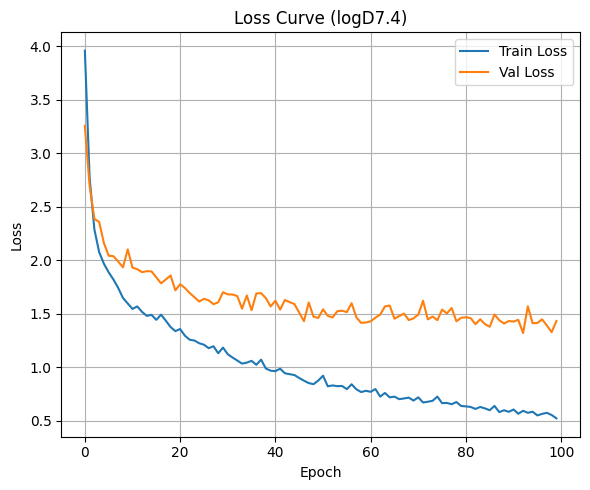

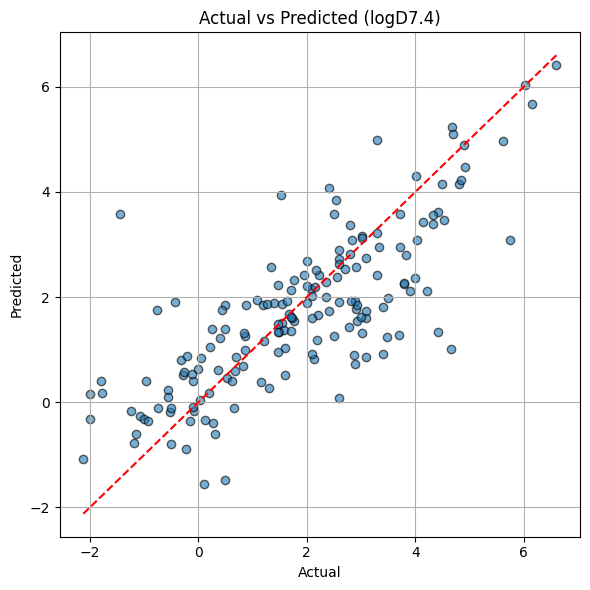

Extracting Transformer features...
Saved Transformer features and targets for logD7.4


/tmp/ipykernel_31/3082777437.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("/kaggle/working/transformer_models/best_model_logD7.4.pt

In [21]:
# --- Flexible Training Example ---
target1 = 'logD7.4' 

# Train/Val/Test Split
train_df1, test_df1 = train_test_split(df, test_size=0.15, random_state=42)
train_df1, val_df1 = train_test_split(train_df1, test_size=0.15, random_state=42)

# Data Loaders
train_loader1 = DataLoader(TransformerDataset(train_df1, smilesVoc, target_col=target1), batch_size=16, shuffle=True)
val_loader1 = DataLoader(TransformerDataset(val_df1, smilesVoc, target_col=target1), batch_size=16)
test_loader1 = DataLoader(TransformerDataset(test_df1, smilesVoc, target_col=target1), batch_size=16)

# Model Args
args1 = {
    'dropout': 0.2,
    'num_layer': 2,
    'num_heads': 2,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1,
    'vocab': smilesVoc
}

model1 = modelTransformer_smi(args1).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=6e-5)
criterion1 = nn.MSELoss()

# Save path
save_path = f"/kaggle/working/transformer_models/best_model_{target1}.pt"
os.makedirs("transformer_models", exist_ok=True)

# Train
train_losses1, val_losses1 = train_model(
    model=model1,
    train_loader=train_loader1,
    val_loader=val_loader1,
    device=device,
    criterion=criterion1,
    optimizer=optimizer1,
    epochs=100,
    model_save_path=save_path
)

# Evaluate and visualize
evaluate_and_plot(
    model=model1,
    model_save_path=save_path,
    test_loader=test_loader1,
    device=device,
    train_losses=train_losses1,
    val_losses=val_losses1,
    target=target1
)

# === Extract & Save Transformer Features ===
print("Extracting Transformer features...")

# Reload best weights
model1.load_state_dict(torch.load("/kaggle/working/transformer_models/best_model_logD7.4.pt", map_location=device))
model1.eval()

all_features = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader1:  # You can also use full_loader if you define one
        x, y = x.to(device), y.to(device)
        mask = getInput_mask(x).to(device)
        encoded = model1.encoder(x, mask)  # (B, L, H)
        pooled = torch.mean(encoded, dim=1)  # (B, H)
        all_features.append(pooled.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Stack and save
features_np = np.vstack(all_features)
targets_np = np.vstack(all_targets)

np.save(f"transformer_features_{target1}.npy", features_np)
np.save(f"transformer_targets_{target1}.npy", targets_np)

print(f"Saved Transformer features and targets for {target1}")

Epoch 1/100 | Train Loss: 6.7130 | Val Loss: 4.7240 | Time: 0.35s
Epoch 2/100 | Train Loss: 3.2708 | Val Loss: 3.4195 | Time: 0.37s
Epoch 3/100 | Train Loss: 1.7324 | Val Loss: 2.6439 | Time: 0.36s
Epoch 4/100 | Train Loss: 1.2474 | Val Loss: 2.3336 | Time: 0.34s
Epoch 5/100 | Train Loss: 1.0524 | Val Loss: 2.1660 | Time: 0.33s
Epoch 6/100 | Train Loss: 1.0336 | Val Loss: 2.0271 | Time: 0.34s
Epoch 7/100 | Train Loss: 0.8825 | Val Loss: 1.8692 | Time: 0.33s
Epoch 8/100 | Train Loss: 0.7841 | Val Loss: 1.8024 | Time: 0.34s
Epoch 9/100 | Train Loss: 0.7637 | Val Loss: 1.6877 | Time: 0.33s
Epoch 10/100 | Train Loss: 0.6925 | Val Loss: 1.6164 | Time: 0.34s
Epoch 11/100 | Train Loss: 0.6418 | Val Loss: 1.5544 | Time: 0.35s
Epoch 12/100 | Train Loss: 0.6351 | Val Loss: 1.4960 | Time: 0.35s
Epoch 13/100 | Train Loss: 0.5930 | Val Loss: 1.4961 | Time: 0.33s
Epoch 14/100 | Train Loss: 0.5889 | Val Loss: 1.4515 | Time: 0.34s
Epoch 15/100 | Train Loss: 0.5753 | Val Loss: 1.4029 | Time: 0.33s
Epoc

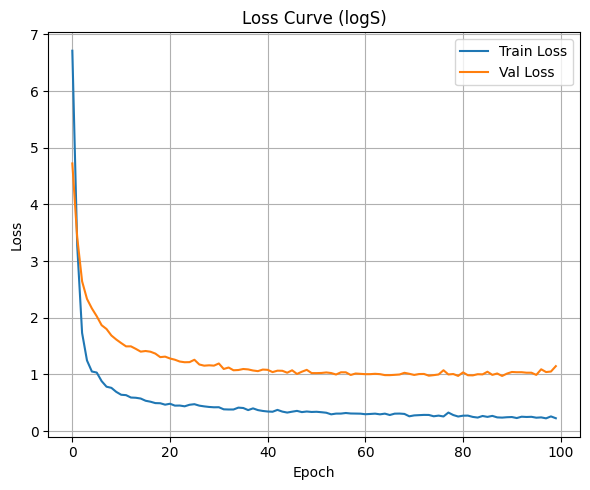

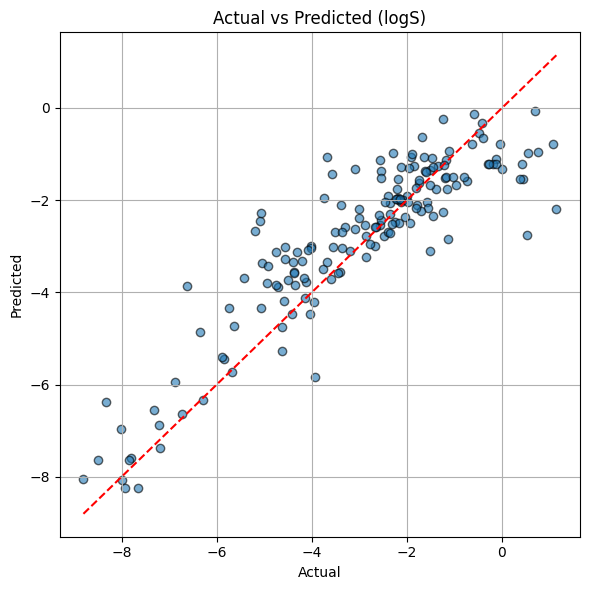

In [22]:
# --- Load Delaney Dataset ---
df2 = pd.read_csv('/kaggle/input/drugdiscoverydatasets/delaney.csv')
df2 = df2[['smiles', 'measured log solubility in mols per litre']]
df2 = df2.rename(columns={'measured log solubility in mols per litre': 'logS'})

# --- Define Target ---
target2 = 'logS'

# --- Extend Vocabulary ---
smiles_list2 = df2['smiles'].tolist()
new_vocab = build_vocab_from_smiles(smiles_list2)
smilesVoc.update(new_vocab)  # Merge into main vocab

# --- Split Delaney Dataset ---
train_df2, test_df2 = train_test_split(df2, test_size=0.15, random_state=42)
train_df2, val_df2 = train_test_split(train_df2, test_size=0.15, random_state=42)

# --- Data Loaders ---
train_loader2 = DataLoader(TransformerDataset(train_df2, smilesVoc, target_col=target2), batch_size=16, shuffle=True)
val_loader2 = DataLoader(TransformerDataset(val_df2, smilesVoc, target_col=target2), batch_size=16)
test_loader2 = DataLoader(TransformerDataset(test_df2, smilesVoc, target_col=target2), batch_size=16)

# --- Model Configuration ---
args2 = {
    'dropout': 0.1,
    'num_layer': 2,
    'num_heads': 2,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1,
    'vocab': smilesVoc
}

# --- Initialize Model and Optimizer ---
model2 = modelTransformer_smi(args2).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=6e-5)
criterion2 = nn.MSELoss()

# --- Train Model ---
train_losses2, val_losses2 = train_model(
    model=model2,
    train_loader=train_loader2,
    val_loader=val_loader2,
    device=device,
    criterion=criterion2,
    optimizer=optimizer2,
    epochs=100,
    model_save_path=f"transformer_models/best_model_{target2}.pt"
)

# --- Evaluate and Plot ---
evaluate_and_plot(
    model=model2,
    model_save_path=f"transformer_models/best_model_{target2}.pt",
    test_loader=test_loader2,
    device=device,
    train_losses=train_losses2,
    val_losses=val_losses2,
    target=target2
)

In [23]:
# Reload best weights
model2.load_state_dict(torch.load("/kaggle/working/transformer_models/best_model_logS.pt", map_location=device))
model2.eval()

all_features = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader2:  # Use the correct test loader for logS
        x, y = x.to(device), y.to(device)
        mask = getInput_mask(x).to(device)
        encoded = model2.encoder(x, mask)  # (B, L, H)
        pooled = torch.mean(encoded, dim=1)  # (B, H)
        all_features.append(pooled.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Stack and save
features_np = np.vstack(all_features)
targets_np = np.vstack(all_targets)

np.save("transformer_features_logS.npy", features_np)
np.save("transformer_targets_logS.npy", targets_np)

print("Saved Transformer features and targets for logS")

Saved Transformer features and targets for logS


/tmp/ipykernel_31/1471922900.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("/kaggle/working/transformer_models/best_model_logS.pt", m

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/100 | Train Loss: 17.4879 | Val Loss: 22.1145 | Time: 0.20s
Epoch 2/100 | Train Loss: 9.8980 | Val Loss: 14.9102 | Time: 0.19s
Epoch 3/100 | Train Loss: 6.7337 | Val Loss: 11.3489 | Time: 0.20s
Epoch 4/100 | Train Loss: 5.1928 | Val Loss: 9.6246 | Time: 0.19s
Epoch 5/100 | Train Loss: 4.6401 | Val Loss: 8.7160 | Time: 0.19s
Epoch 6/100 | Train Loss: 4.2304 | Val Loss: 8.1320 | Time: 0.19s
Epoch 7/100 | Train Loss: 4.0827 | Val Loss: 7.7060 | Time: 0.19s
Epoch 8/100 | Train Loss: 3.6707 | Val Loss: 7.0430 | Time: 0.19s
Epoch 9/100 | Train Loss: 3.3915 | Val Loss: 6.9743 | Time: 0.19s
Epoch 10/100 | Train Loss: 3.0549 | Val Loss: 6.7474 | Time: 0.20s
Epoch 11/100 | Train Loss: 2.7582 | Val Loss: 6.2313 | Time: 0.20s
Epoch 12/100 | Train Loss: 2.6649 | Val Loss: 5.7442 | Time: 0.19s
Epoch 13/100 | Train Loss: 2.6108 | Val Loss: 4.9369 | Time: 0.20s
Epoch 14/100 | Train Loss: 2.3846 | Val Loss: 4.9713 | Time: 0.20s
Epoch 15/100 | Train Loss: 2.2810 | Val Loss: 4.8196 | Time: 0.19s


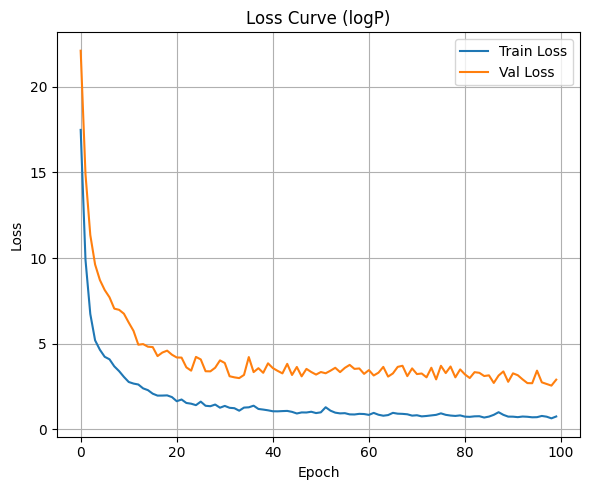

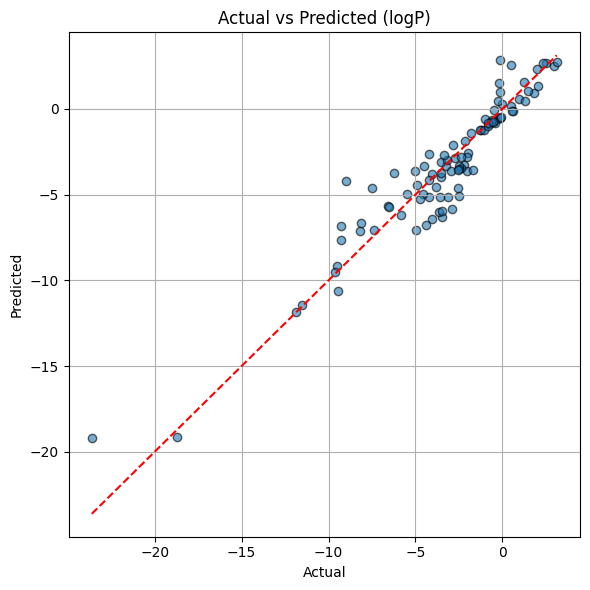

In [24]:
# --- Load SAMPL Dataset ---
df4 = pd.read_csv('/kaggle/input/drugdiscoverydatasets/SAMPL.csv')
df4 = df4[['smiles', 'expt']].rename(columns={'expt': 'logP'})
target4 = 'logP'

# --- Extend main vocab ---
smiles_list4 = df4['smiles'].tolist()
smilesVoc4 = build_vocab_from_smiles(smiles_list4)
smilesVoc.update(smilesVoc4)  # Merge into global vocab

# --- Split Dataset ---
train_df4, test_df4 = train_test_split(df4, test_size=0.15, random_state=42)
train_df4, val_df4 = train_test_split(train_df4, test_size=0.15, random_state=42)

# --- Data Loaders ---
train_loader4 = DataLoader(TransformerDataset(train_df4, smilesVoc, target_col=target4), batch_size=16, shuffle=True)
val_loader4 = DataLoader(TransformerDataset(val_df4, smilesVoc, target_col=target4), batch_size=16)
test_loader4 = DataLoader(TransformerDataset(test_df4, smilesVoc, target_col=target4), batch_size=16)

# --- Model Configuration ---
args4 = {
    'dropout': 0.1,
    'num_layer': 2,
    'num_heads': 1,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1,
    'vocab': smilesVoc
}

model4 = modelTransformer_smi(args4).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-4)
criterion4 = nn.MSELoss()

# --- Train Model ---
train_losses4, val_losses4 = train_model(
    model=model4,
    train_loader=train_loader4,
    val_loader=val_loader4,
    device=device,
    criterion=criterion4,
    optimizer=optimizer4,
    epochs=100,
    model_save_path="transformer_models/transformer_model_logP.pt"
)

# --- Evaluate ---
evaluate_and_plot(
    model=model4,
    model_save_path="transformer_models/transformer_model_logP.pt",
    test_loader=test_loader4,
    device=device,
    train_losses=train_losses4,
    val_losses=val_losses4,
    target=target4
)

In [25]:
# Reload best weights
model4.load_state_dict(torch.load("/kaggle/working/transformer_models/transformer_model_logP.pt", map_location=device))
model4.eval()

all_features = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader4:  # Use correct loader for logP
        x, y = x.to(device), y.to(device)
        mask = getInput_mask(x).to(device)
        encoded = model4.encoder(x, mask)  # (B, L, H)
        pooled = torch.mean(encoded, dim=1)  # (B, H)
        all_features.append(pooled.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Stack and save
features_np = np.vstack(all_features)
targets_np = np.vstack(all_targets)

np.save("transformer_features_logP.npy", features_np)
np.save("transformer_targets_logP.npy", targets_np)

print("Saved Transformer features and targets for logP")


Saved Transformer features and targets for logP


/tmp/ipykernel_31/876848646.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load("/kaggle/working/transformer_models/transformer_model_logP.

## BiGRU

In [30]:
def load_dataset(csv_file, targets, sep=',', exclude_mollogp=False):
    df = pd.read_csv(csv_file, sep=sep)
    data_list = []
    smiles_col = 'smiles' if 'smiles' in df.columns else 'SMILES'
    raw_descriptors = []
    smiles_list = []

    for _, row in df.iterrows():
        smiles = row[smiles_col]
        desc = compute_global_descriptors(smiles, exclude_mollogp=exclude_mollogp)
        if desc is not None:
            raw_descriptors.append(desc)
            smiles_list.append((smiles, row))

    if not raw_descriptors:
        print("No valid molecules found for descriptor extraction.")
        return []

    scaler = StandardScaler()
    raw_descriptors = np.array(raw_descriptors)
    scaler.fit(raw_descriptors)

    for i, (smiles, row) in enumerate(smiles_list):
        graph = mol_to_graph(smiles)
        if graph is None:
            continue
        try:
            graph.y = torch.tensor(row[targets].astype(float).values, dtype=torch.float)
            normed_global = scaler.transform(raw_descriptors[i].reshape(1, -1)).flatten()
            graph.global_x = torch.tensor(normed_global, dtype=torch.float)
            data_list.append(graph)
        except:
            continue

    return data_list

In [26]:
class modelBiGRU_Attention(nn.Module):
    def __init__(self, num_features=7, hidden_dim=256, output_dim=1, num_layers=2, dropout=0.3, bidirectional=True, global_dim=10):
        super(modelBiGRU_Attention, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        self.layer_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)

        self.attention = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)

        fusion_input_dim = (hidden_dim * 2 if bidirectional else hidden_dim) + global_dim

        self.fusion_mlp = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x, batch, global_x):
        batch_size = batch.max().item() + 1
        max_num_nodes = batch.bincount().max().item()
        node_dim = x.size(1)

        padded_x = torch.zeros((batch_size, max_num_nodes, node_dim), device=x.device)
        for graph_idx in range(batch_size):
            node_idx = (batch == graph_idx).nonzero(as_tuple=True)[0]
            padded_x[graph_idx, :len(node_idx), :] = x[node_idx]

        output, _ = self.gru(padded_x)
        output = self.layer_norm(output)

        attn_scores = self.attention(output)
        attn_scores = F.softmax(attn_scores, dim=1)

        attn_output = (output * attn_scores).sum(dim=1)

        x = self.dropout(attn_output)

        if global_x.dim() == 1 or global_x.shape[0] != x.shape[0]:
            global_x = global_x.view(x.size(0), -1)

        x = torch.cat([x, global_x], dim=1)
        return self.fusion_mlp(x)

In [27]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, target_names, max_epochs=150, patience=15):
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    train_losses, val_losses = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            global_feats = torch.stack([d.global_x for d in data.to_data_list()]).to(device)
            output = model(data.x, data.batch, global_feats)
            loss = criterion(output, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        preds, trues = evaluate(model, val_loader, device, target_names)
        val_loss = mean_squared_error(trues, preds)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate(model, loader, device, target_names):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            global_feats = torch.stack([d.global_x for d in data.to_data_list()]).to(device)
            output = model(data.x, data.batch, global_feats)
            preds.append(output.cpu().numpy())
            trues.append(data.y.view(-1, 1).cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    return preds, trues

def print_metrics(preds, trues, target_names):
    for i, name in enumerate(target_names):
        mse = mean_squared_error(trues[:, i], preds[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(trues[:, i], preds[:, i])
        r2 = r2_score(trues[:, i], preds[:, i])
        corr, _ = pearsonr(trues[:, i], preds[:, i])
        print(f"\n{name}:")
        print(f"  RMSE: {rmse:.4f} | MSE: {mse:.4f}")
        print(f"  MAE : {mae:.4f} | R² : {r2:.4f}")
        print(f"  Pearson Correlation: {corr:.4f}")

# ========================== Visualization Functions ==========================

def plot_loss_curve(train_losses, val_losses, dataset_name):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_true_vs_pred(trues, preds, target_names, dataset_name):
    for i, name in enumerate(target_names):
        plt.figure(figsize=(6,6))
        plt.scatter(trues[:,i], preds[:,i], edgecolors='k', alpha=0.7)
        plt.plot([trues[:,i].min(), trues[:,i].max()], [trues[:,i].min(), trues[:,i].max()], 'r--')
        plt.xlabel(f"True {name}")
        plt.ylabel(f"Predicted {name}")
        plt.title(f"True vs Predicted - {dataset_name} ({name})")
        plt.grid(True)
        plt.show()

def plot_residual_distribution(trues, preds, target_names, dataset_name):
    for i, name in enumerate(target_names):
        residuals = trues[:,i] - preds[:,i]
        plt.figure(figsize=(6,5))
        sns.histplot(residuals, kde=True, bins=30)
        plt.xlabel("Residuals (True - Predicted)")
        plt.title(f"Residuals Distribution - {dataset_name} ({name})")
        plt.grid(True)
        plt.show()

def save_predictions(trues, preds, dataset_name):
    df = pd.DataFrame({
        "True": trues.flatten(),
        "Predicted": preds.flatten(),
        "Residual": (trues - preds).flatten()
    })
    df.to_csv(f"{dataset_name}_predictions.csv", index=False)
    print(f"Saved predictions and residuals to {dataset_name}_predictions.csv")

# ========================== Setup Random Seed ==========================

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [34]:
def run_pipeline(csv_file, targets, dataset_name, sep=','):
    set_seed(42)
    print(f"\nRunning on {dataset_name} dataset")

    if not csv_file:
        csv_file = download_dataset_if_missing(dataset_name)

    # Load data
    data = load_dataset(csv_file, targets, sep=sep)
    if len(data) == 0:
        print("No valid molecular graphs found. Exiting.")
        return

    print(f"Loaded {len(data)} molecular graphs.")
    
    global_dim = len(data[0].global_x)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    output_dim = len(targets)
    model = modelBiGRU_Attention(output_dim=output_dim, global_dim=global_dim, num_features=7).to(device)

    # Data splits
    train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)
    test_loader = DataLoader(test_data, batch_size=32)

    # Optimizer, Scheduler, Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Train
    model, train_losses, val_losses = train(
        model, train_loader, val_loader, optimizer, scheduler, criterion, device, targets
    )

    # Evaluate
    preds, trues = evaluate(model, test_loader, device, targets)
    print_metrics(preds, trues, targets)

    # === Save BiGRU features and targets ===
    model.eval()
    all_features = []
    all_targets = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            global_feats = torch.stack([d.global_x for d in data.to_data_list()]).to(device)
    
            batch_size = data.batch.max().item() + 1
            max_num_nodes = data.batch.bincount().max().item()
            node_dim = data.x.size(1)
    
            padded_x = torch.zeros((batch_size, max_num_nodes, node_dim), device=data.x.device)
            for graph_idx in range(batch_size):
                node_idx = (data.batch == graph_idx).nonzero(as_tuple=True)[0]
                padded_x[graph_idx, :len(node_idx), :] = data.x[node_idx]
    
            output, _ = model.gru(padded_x)
            output = model.layer_norm(output)
            attn_scores = F.softmax(model.attention(output), dim=1)
            attn_output = (output * attn_scores).sum(dim=1)
            features = model.dropout(attn_output)  # This is the representation you want
    
            all_features.append(features.cpu().numpy())
            all_targets.append(data.y.view(-1, 1).cpu().numpy())
    
    # Save as .npy
    features_np = np.vstack(all_features)
    targets_np = np.vstack(all_targets)
    
    np.save(f"bigru_features_{dataset_name}.npy", features_np)
    np.save(f"bigru_targets_{dataset_name}.npy", targets_np)
    
    print(f"Saved BiGRU features and targets for {dataset_name}")

    # Visualizations
    plot_loss_curve(train_losses, val_losses, dataset_name)
    plot_true_vs_pred(trues, preds, targets, dataset_name)
    plot_residual_distribution(trues, preds, targets, dataset_name)

    # Save predictions
    save_predictions(trues, preds, dataset_name)

    # Save model
    os.makedirs("bigru_models", exist_ok=True)
    model_path = f"bigru_models/{dataset_name}_bigru_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")


Running on Delaney dataset
Loaded 1128 molecular graphs.


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001 | Train Loss: 5.5568 | Val Loss: 4.0287
Epoch 002 | Train Loss: 3.3079 | Val Loss: 2.6493
Epoch 003 | Train Loss: 2.7316 | Val Loss: 2.1388
Epoch 004 | Train Loss: 2.1071 | Val Loss: 1.4835
Epoch 005 | Train Loss: 1.9796 | Val Loss: 1.4339
Epoch 006 | Train Loss: 1.6847 | Val Loss: 1.1740
Epoch 007 | Train Loss: 1.5022 | Val Loss: 1.2884
Epoch 008 | Train Loss: 1.4814 | Val Loss: 1.3221
Epoch 009 | Train Loss: 1.3701 | Val Loss: 1.2670
Epoch 010 | Train Loss: 1.3295 | Val Loss: 1.4037
Epoch 011 | Train Loss: 1.4901 | Val Loss: 1.3505
Epoch 012 | Train Loss: 1.4714 | Val Loss: 0.9400
Epoch 013 | Train Loss: 1.2690 | Val Loss: 0.9866
Epoch 014 | Train Loss: 1.2716 | Val Loss: 1.1143
Epoch 015 | Train Loss: 1.3283 | Val Loss: 1.1708
Epoch 016 | Train Loss: 1.2780 | Val Loss: 0.8742
Epoch 017 | Train Loss: 1.2531 | Val Loss: 0.8826
Epoch 018 | Train Loss: 1.2546 | Val Loss: 0.8737
Epoch 019 | Train Loss: 1.1521 | Val Loss: 0.8977
Epoch 020 | Train Loss: 1.1817 | Val Loss: 0.9251


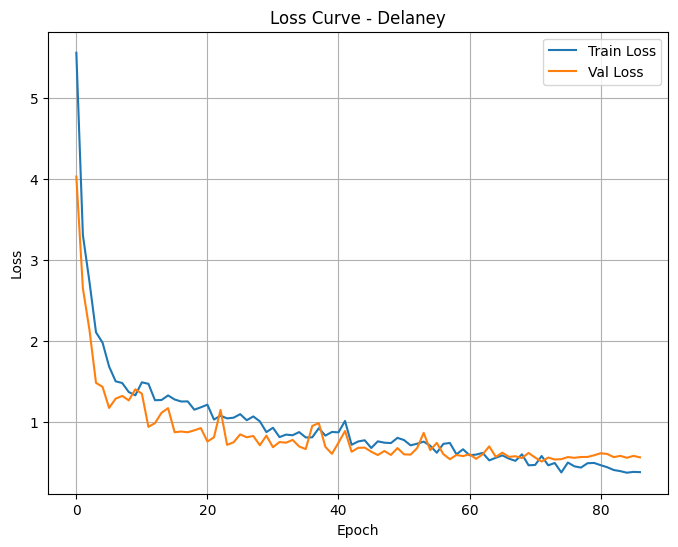

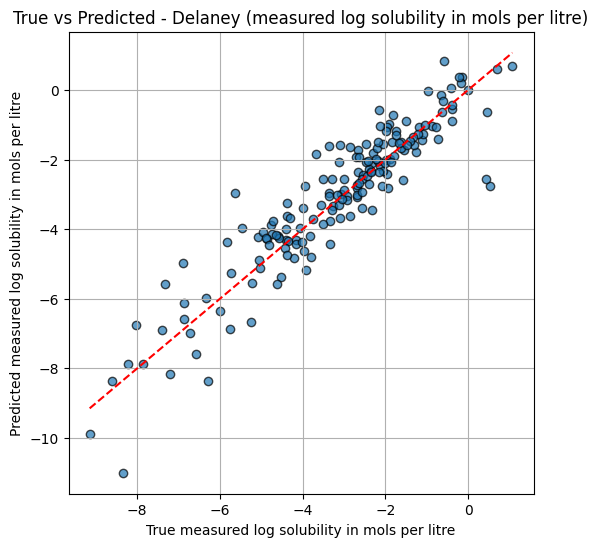

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


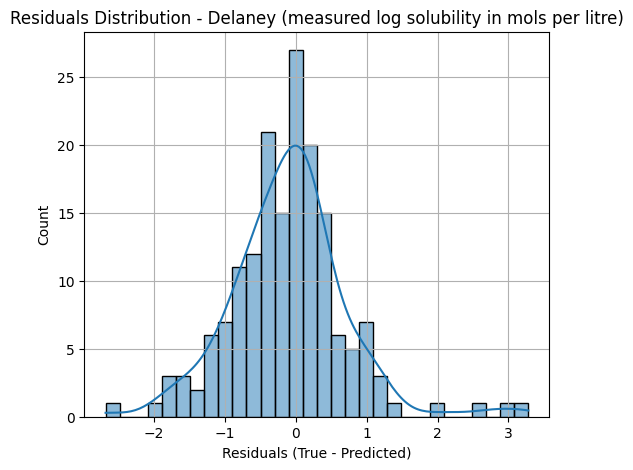

Saved predictions and residuals to Delaney_predictions.csv
Model saved to: bigru_models/Delaney_bigru_model.pth

Running on logD74 dataset
Loaded 1130 molecular graphs.


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001 | Train Loss: 3.5787 | Val Loss: 3.2495
Epoch 002 | Train Loss: 3.1175 | Val Loss: 2.8279
Epoch 003 | Train Loss: 2.9357 | Val Loss: 2.9799
Epoch 004 | Train Loss: 2.8721 | Val Loss: 2.6139
Epoch 005 | Train Loss: 2.6124 | Val Loss: 2.5774
Epoch 006 | Train Loss: 2.5118 | Val Loss: 2.7087
Epoch 007 | Train Loss: 2.4049 | Val Loss: 2.2421
Epoch 008 | Train Loss: 2.2806 | Val Loss: 2.7481
Epoch 009 | Train Loss: 2.0899 | Val Loss: 2.2427
Epoch 010 | Train Loss: 2.0474 | Val Loss: 1.8129
Epoch 011 | Train Loss: 1.9909 | Val Loss: 1.7596
Epoch 012 | Train Loss: 1.9853 | Val Loss: 1.7260
Epoch 013 | Train Loss: 1.7854 | Val Loss: 1.6456
Epoch 014 | Train Loss: 1.8968 | Val Loss: 1.7711
Epoch 015 | Train Loss: 1.8421 | Val Loss: 1.5867
Epoch 016 | Train Loss: 1.7327 | Val Loss: 2.0539
Epoch 017 | Train Loss: 1.6832 | Val Loss: 1.4738
Epoch 018 | Train Loss: 1.7049 | Val Loss: 1.4864
Epoch 019 | Train Loss: 1.5282 | Val Loss: 1.4790
Epoch 020 | Train Loss: 1.7416 | Val Loss: 1.4864


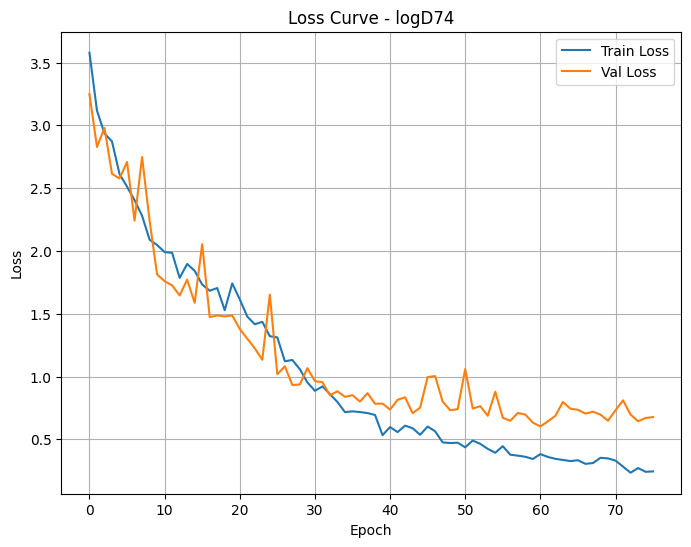

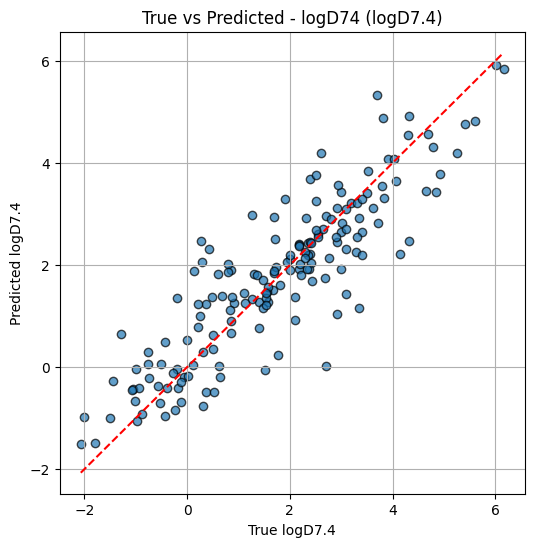

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


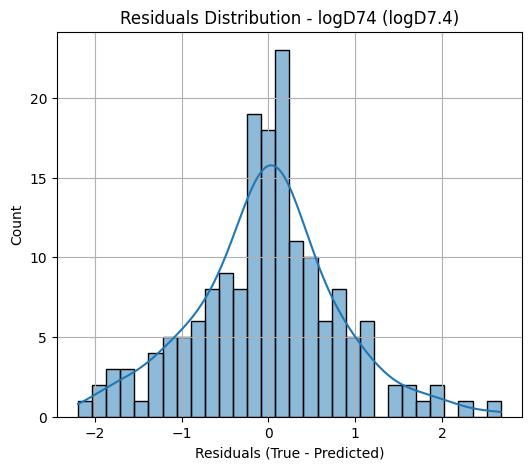

Saved predictions and residuals to logD74_predictions.csv
Model saved to: bigru_models/logD74_bigru_model.pth

Running on SAMPL dataset
Loaded 642 molecular graphs.


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001 | Train Loss: 17.0085 | Val Loss: 23.4143
Epoch 002 | Train Loss: 13.1335 | Val Loss: 20.4522
Epoch 003 | Train Loss: 12.6534 | Val Loss: 19.0739
Epoch 004 | Train Loss: 10.8272 | Val Loss: 17.8638
Epoch 005 | Train Loss: 10.7915 | Val Loss: 15.9524
Epoch 006 | Train Loss: 9.4466 | Val Loss: 14.4817
Epoch 007 | Train Loss: 8.8688 | Val Loss: 13.6569
Epoch 008 | Train Loss: 8.0250 | Val Loss: 11.7833
Epoch 009 | Train Loss: 7.3853 | Val Loss: 10.8193
Epoch 010 | Train Loss: 7.0566 | Val Loss: 11.8523
Epoch 011 | Train Loss: 6.9505 | Val Loss: 7.8788
Epoch 012 | Train Loss: 5.3923 | Val Loss: 6.4704
Epoch 013 | Train Loss: 5.0696 | Val Loss: 6.0048
Epoch 014 | Train Loss: 4.6791 | Val Loss: 5.4056
Epoch 015 | Train Loss: 4.5957 | Val Loss: 4.6107
Epoch 016 | Train Loss: 4.4241 | Val Loss: 4.5399
Epoch 017 | Train Loss: 4.6741 | Val Loss: 4.2512
Epoch 018 | Train Loss: 4.2483 | Val Loss: 3.7649
Epoch 019 | Train Loss: 4.4159 | Val Loss: 3.9860
Epoch 020 | Train Loss: 3.8145 | Va

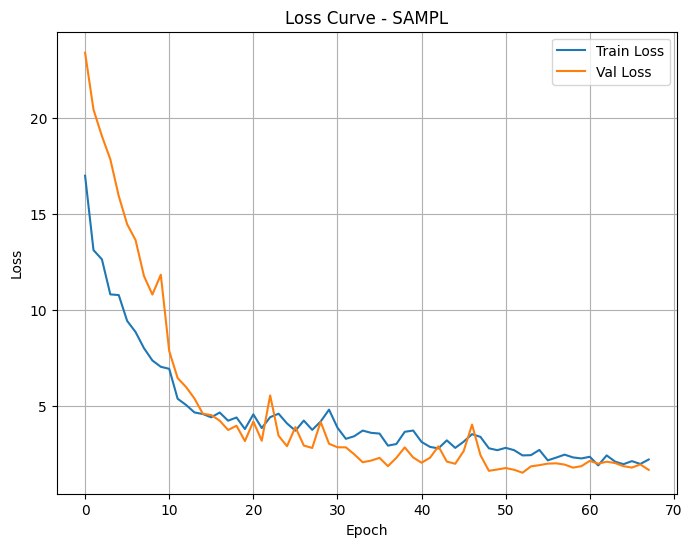

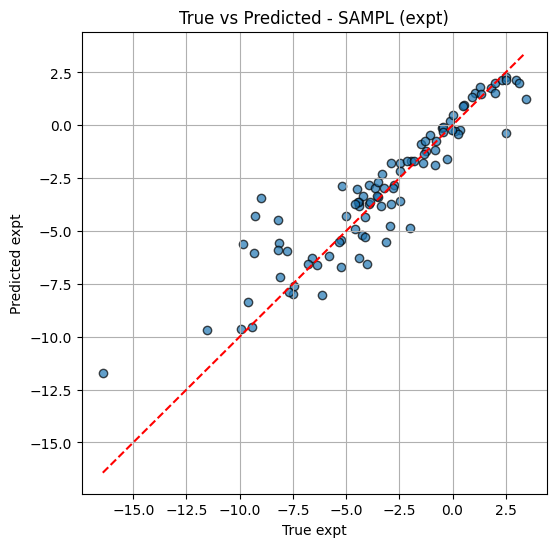

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


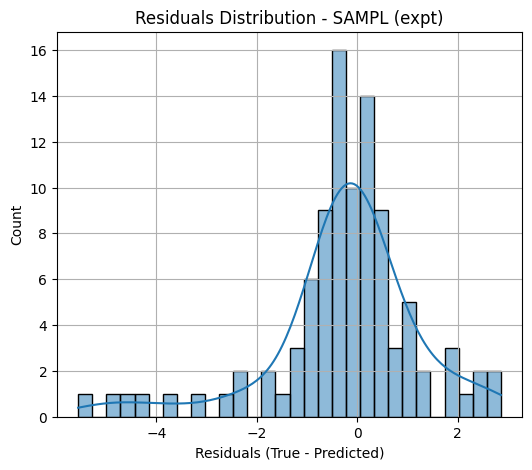

Saved predictions and residuals to SAMPL_predictions.csv
Model saved to: bigru_models/SAMPL_bigru_model.pth


In [35]:
run_pipeline("/kaggle/input/drugdiscoverydatasets/delaney.csv", ['measured log solubility in mols per litre'], "Delaney")

run_pipeline("/kaggle/input/drugdiscoverydatasets/logd74.tsv", ['logD7.4'], "logD74", sep="\t")

run_pipeline("/kaggle/input/drugdiscoverydatasets/SAMPL.csv", ['expt'], "SAMPL")

## 3D MLP

In [40]:
# === Dataset and MLP Architecture ===
class EC3FPDataset(Dataset):
    def __init__(self, csv_path, target_col):
        df = pd.read_csv(csv_path)
        df = df[["smiles", "ec3fp", target_col]].dropna()
        df["ec3fp"] = df["ec3fp"].apply(lambda x: list(map(int, x.split(","))))
        self.fp_data = df["ec3fp"].to_list()
        self.targets = df[target_col].values

    def __len__(self):
        return len(self.fp_data)

    def __getitem__(self, idx):
        ec3fp = torch.tensor(self.fp_data[idx], dtype=torch.float32)
        target = torch.tensor([self.targets[idx]], dtype=torch.float32)
        return ec3fp, target

class MLP_EC3FP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [41]:
# === Training Function ===
def train_model(model, train_loader, val_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()

    model_save_path = os.path.join(config["save_dir"], f"{config['model_number']}_{config['target_col']}.pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    total_start = time.time()

    for epoch in range(config["epochs"]):
        epoch_start = time.time()
        model.train()
        running_loss = 0
        for ec3fp, target in train_loader:
            ec3fp, target = ec3fp.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(ec3fp)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for ec3fp, target in val_loader:
                ec3fp, target = ec3fp.to(device), target.to(device)
                outputs = model(ec3fp)
                val_loss += criterion(outputs, target).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{config['epochs']} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"\nTraining complete in {total_time:.2f} seconds.")

    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [42]:
# === Evaluation Function ===
def evaluate_model(model, test_loader, config):
    model_save_path = os.path.join(config["save_dir"], f"{config['model_number']}_{config['target_col']}.pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_save_path))
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for ec3fp, target in test_loader:
            ec3fp, target = ec3fp.to(device), target.to(device)
            outputs = model(ec3fp)
            y_true.extend(target.squeeze().cpu().numpy())
            y_pred.extend(outputs.squeeze().cpu().numpy())

    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pearson = np.corrcoef(y_true, y_pred)[0,1]

    print("\nTest Set Evaluation Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Pearson: {pearson:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.grid(True)
    plt.show()

In [43]:
# === Feature Extraction ===
def extract_features(model, loader, config):
    model_save_path = os.path.join(config["save_dir"], f"{config['model_number']}_{config['target_col']}.pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_save_path))
    model.to(device)
    model.eval()

    features = []
    targets = []

    with torch.no_grad():
        for ec3fp, target in loader:
            ec3fp = ec3fp.to(device)
            x = model.net[:-1](ec3fp)  # Features before final prediction layer
            features.append(x.cpu().numpy())
            targets.append(target.cpu().numpy())

    features_np = np.vstack(features)
    targets_np = np.vstack(targets)

    np.save(f"ec3fp_features_{config['target_col']}.npy", features_np)
    np.save(f"ec3fp_targets_{config['target_col']}.npy", targets_np)

    print(f"Saved features and targets for {config['target_col']}")

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50 - Train Loss: 5.3237 - Val Loss: 3.8867 - Time: 0.13s
Epoch 2/50 - Train Loss: 3.1684 - Val Loss: 2.7899 - Time: 0.13s
Epoch 3/50 - Train Loss: 2.4425 - Val Loss: 2.3632 - Time: 0.13s
Epoch 4/50 - Train Loss: 1.7879 - Val Loss: 1.8987 - Time: 0.13s
Epoch 5/50 - Train Loss: 1.2434 - Val Loss: 1.7022 - Time: 0.14s
Epoch 6/50 - Train Loss: 0.9494 - Val Loss: 1.5742 - Time: 0.13s
Epoch 7/50 - Train Loss: 0.7099 - Val Loss: 1.4741 - Time: 0.13s
Epoch 8/50 - Train Loss: 0.5458 - Val Loss: 1.4387 - Time: 0.13s
Epoch 9/50 - Train Loss: 0.4130 - Val Loss: 1.4241 - Time: 0.14s
Epoch 10/50 - Train Loss: 0.3179 - Val Loss: 1.4591 - Time: 0.14s
Epoch 11/50 - Train Loss: 0.2399 - Val Loss: 1.4913 - Time: 0.13s
Epoch 12/50 - Train Loss: 0.1826 - Val Loss: 1.5002 - Time: 0.13s
Epoch 13/50 - Train Loss: 0.1352 - Val Loss: 1.4899 - Time: 0.14s
Epoch 14/50 - Train Loss: 0.1041 - Val Loss: 1.5075 - Time: 0.14s
Epoch 15/50 - Train Loss: 0.0722 - Val Loss: 1.5021 - Time: 0.14s
Epoch 16/50 - Train

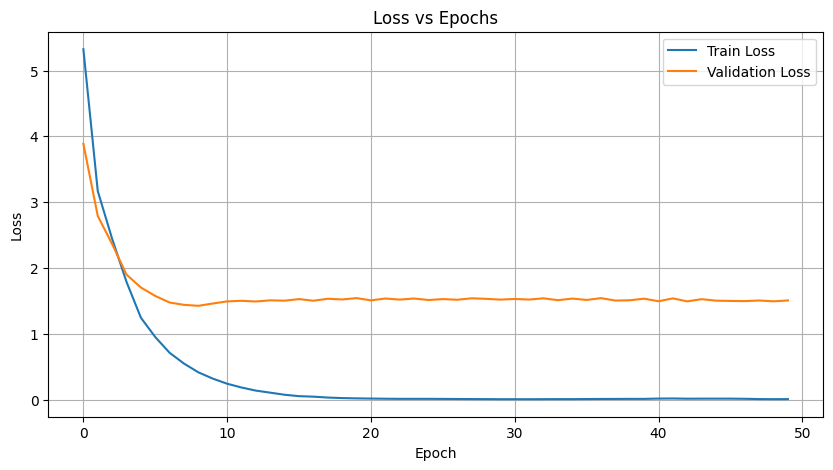


Test Set Evaluation Metrics:
RMSE: 1.0530
MAE:  0.8374
R²: 0.6160
Pearson: 0.7857


/tmp/ipykernel_31/2904940707.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


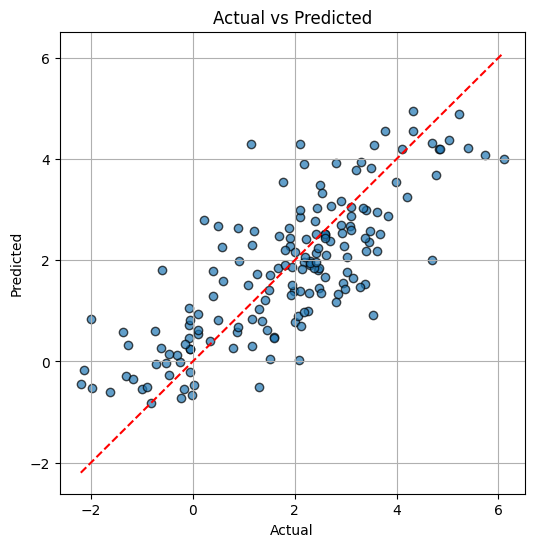

Saved features and targets for logD


/tmp/ipykernel_31/1185198765.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


In [46]:
# --- Config for logD ---
config1 = {
    "csv_path": "/kaggle/input/drugdiscoverydatasets/logd_with_ec3fp.csv",
    "input_dim": 1024,
    "hidden_dims": [128, 32],
    "output_dim": 1,
    "batch_size": 32,
    "learning_rate": 5e-4,
    "epochs": 50,
    "model_number": "model1",
    "target_col": "logD",
    "save_dir": "/kaggle/working/",
}

# --- Loaders ---
full_dataset1 = EC3FPDataset(config1["csv_path"], config1["target_col"])
train_idx1, temp_idx1 = train_test_split(range(len(full_dataset1)), test_size=0.3, random_state=42)
val_idx1, test_idx1 = train_test_split(temp_idx1, test_size=0.5, random_state=42)
train_loader1 = DataLoader(torch.utils.data.Subset(full_dataset1, train_idx1), batch_size=config1["batch_size"], shuffle=True)
val_loader1 = DataLoader(torch.utils.data.Subset(full_dataset1, val_idx1), batch_size=config1["batch_size"])
test_loader1 = DataLoader(torch.utils.data.Subset(full_dataset1, test_idx1), batch_size=config1["batch_size"])

# --- Train + Evaluate + Extract ---
model1 = MLP_EC3FP(config1["input_dim"], config1["hidden_dims"], config1["output_dim"])
train_model(model1, train_loader1, val_loader1, config1)
evaluate_model(model1, test_loader1, config1)
extract_features(model1, test_loader1, config1)

In [48]:
def extract_features(model, data_loader, config):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(os.path.join(config["save_dir"], f"{config['model_number']}_{config['target_col']}.pt")))
    model.to(device)

    features = []
    targets = []

    with torch.no_grad():
        for ec3fp, target in data_loader:
            ec3fp = ec3fp.to(device)
            x = model.net[:-1](ec3fp)  # Take output before final layer
            features.append(x.cpu().numpy())
            targets.append(target.cpu().numpy())

    features = np.vstack(features)
    targets = np.vstack(targets)

    np.save(f"ec3fp_features_{config['target_col']}.npy", features)
    np.save(f"ec3fp_targets_{config['target_col']}.npy", targets)

    print(f"Saved EC3FP features and targets for {config['target_col']}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50 - Train Loss: 10.8480 - Val Loss: 12.0354 - Time: 0.14s
Epoch 2/50 - Train Loss: 10.5108 - Val Loss: 11.7500 - Time: 0.14s
Epoch 3/50 - Train Loss: 10.1316 - Val Loss: 11.3218 - Time: 0.14s
Epoch 4/50 - Train Loss: 9.5965 - Val Loss: 10.6557 - Time: 0.13s
Epoch 5/50 - Train Loss: 8.6718 - Val Loss: 9.6421 - Time: 0.13s
Epoch 6/50 - Train Loss: 7.4789 - Val Loss: 8.4032 - Time: 0.13s
Epoch 7/50 - Train Loss: 6.1285 - Val Loss: 7.0745 - Time: 0.14s
Epoch 8/50 - Train Loss: 4.8570 - Val Loss: 5.8602 - Time: 0.14s
Epoch 9/50 - Train Loss: 3.8045 - Val Loss: 4.9726 - Time: 0.14s
Epoch 10/50 - Train Loss: 3.1857 - Val Loss: 4.4066 - Time: 0.13s
Epoch 11/50 - Train Loss: 2.8357 - Val Loss: 4.0479 - Time: 0.14s
Epoch 12/50 - Train Loss: 2.6110 - Val Loss: 3.7648 - Time: 0.14s
Epoch 13/50 - Train Loss: 2.4225 - Val Loss: 3.5341 - Time: 0.14s
Epoch 14/50 - Train Loss: 2.2441 - Val Loss: 3.2856 - Time: 0.13s
Epoch 15/50 - Train Loss: 2.0646 - Val Loss: 3.0611 - Time: 0.13s
Epoch 16/50 

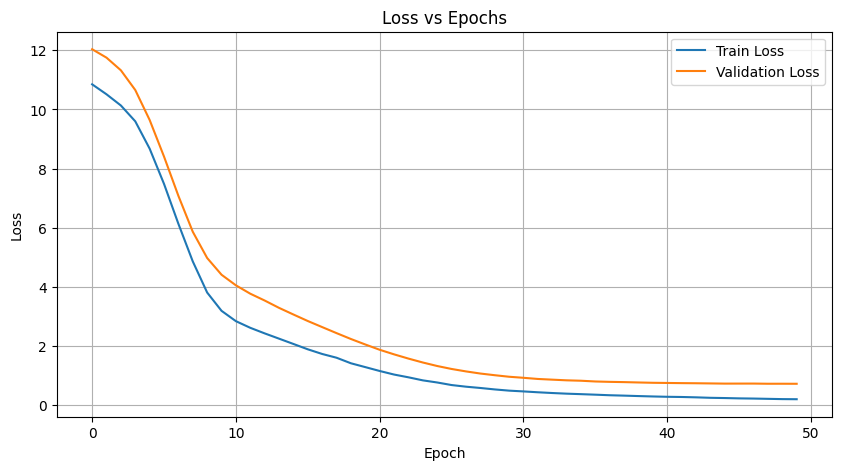


Test Set Evaluation Metrics:
RMSE: 0.7858
MAE:  0.5719
R²: 0.7761
Pearson: 0.8839


/tmp/ipykernel_31/2904940707.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


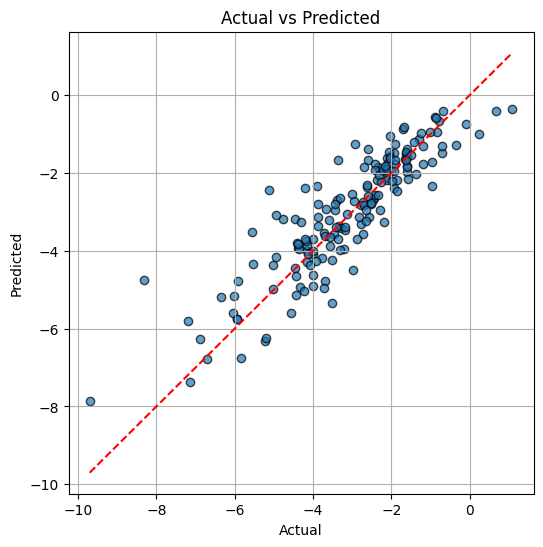

/tmp/ipykernel_31/774368780.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config["save_dir"], f"{config['model_number']}_

Saved EC3FP features and targets for logS


In [50]:
# --- Config for logS ---
config2 = {
    "csv_path": "/kaggle/input/drugdiscoverydatasets/delaney_with_ec3fp.csv",
    "input_dim": 1024,
    "hidden_dims": [128, 32],
    "output_dim": 1,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "epochs": 50,
    "model_number": "model2",
    "target_col": "logS",
    "save_dir": "/kaggle/working/",
}

# --- Loaders ---
full_dataset2 = EC3FPDataset(config2["csv_path"], config2["target_col"])
train_idx2, temp_idx2 = train_test_split(range(len(full_dataset2)), test_size=0.3, random_state=42)
val_idx2, test_idx2 = train_test_split(temp_idx2, test_size=0.5, random_state=42)
train_loader2 = DataLoader(torch.utils.data.Subset(full_dataset2, train_idx2), batch_size=config2["batch_size"], shuffle=True)
val_loader2 = DataLoader(torch.utils.data.Subset(full_dataset2, val_idx2), batch_size=config2["batch_size"])
test_loader2 = DataLoader(torch.utils.data.Subset(full_dataset2, test_idx2), batch_size=config2["batch_size"])

# --- Train + Evaluate + Extract ---
model2 = MLP_EC3FP(config2["input_dim"], config2["hidden_dims"], config2["output_dim"])
train_model(model2, train_loader2, val_loader2, config2)
evaluate_model(model2, test_loader2, config2)
extract_features(model2, test_loader2, config2)

## Fusion

In [57]:
def evaluate_and_plot(model, X_test, y_test, name):
    preds = model.predict(X_test).flatten()
    true = y_test.flatten()

    mse = mean_squared_error(true, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pearson_r, _ = pearsonr(true, preds)

    print(f"\n--- {name} ---")
    print(f"RMSE     : {rmse:.4f}")
    print(f"MSE      : {mse:.4f}")
    print(f"MAE      : {mae:.4f}")
    print(f"R²       : {r2:.4f}")
    print(f"Pearson r: {pearson_r:.4f}")

    plt.figure(figsize=(5, 5))
    plt.scatter(true, preds, alpha=0.5, edgecolor='k')
    plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name}\nPearson r={pearson_r:.2f}')
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'{name}_actual_vs_pred.png', dpi=300)  # Optional
    plt.show()


===== Running Tri-fusion for task: logP =====

--- Tri_LASSO (logP) ---
RMSE     : 1.6428
MSE      : 2.6988
MAE      : 1.1782
R²       : 0.8709
Pearson r: 0.9366


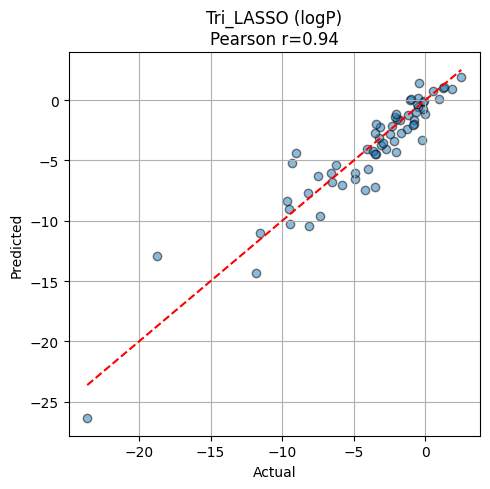


--- Tri_Elastic (logP) ---
RMSE     : 2.1966
MSE      : 4.8250
MAE      : 1.6175
R²       : 0.7692
Pearson r: 0.8998


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+00, tolerance: 1.977e-01
  model = cd_fast.enet_coordinate_descent(


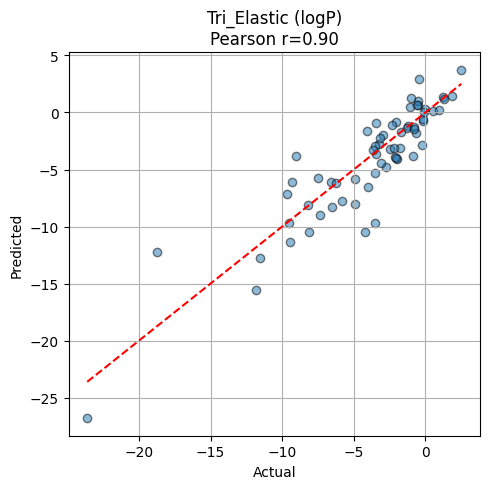


--- Tri_RF (logP) ---
RMSE     : 2.4573
MSE      : 6.0383
MAE      : 1.5581
R²       : 0.7112
Pearson r: 0.8541


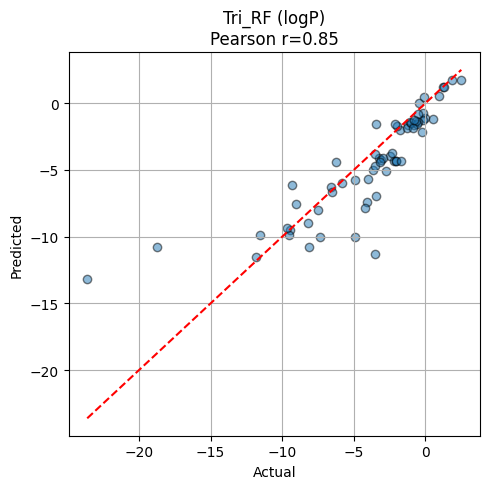


--- Tri_GB (logP) ---
RMSE     : 2.2391
MSE      : 5.0137
MAE      : 1.2803
R²       : 0.7602
Pearson r: 0.8787


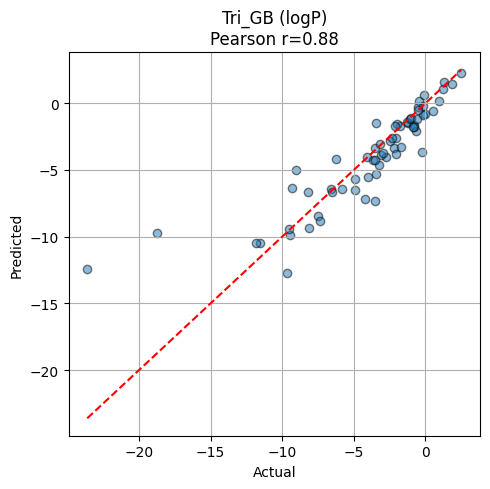


--- Tri_SGD (logP) ---
RMSE     : 1857.3893
MSE      : 3449895.0614
MAE      : 1486.0474
R²       : -165008.8993
Pearson r: -0.0872


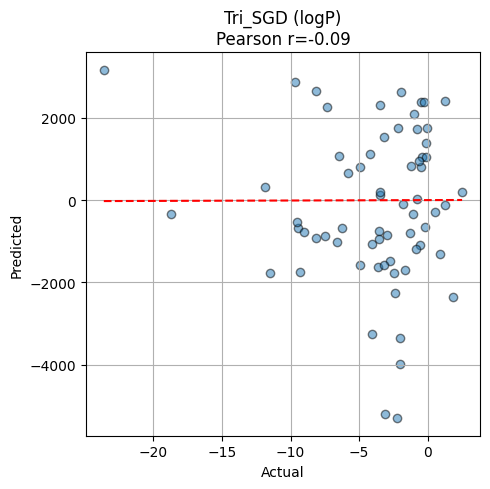


Best Tri-fusion model for logP: Tri_LASSO with RMSE 1.6428

===== Running Tri-fusion for task: logS =====

--- Tri_LASSO (logS) ---
RMSE     : 0.8493
MSE      : 0.7214
MAE      : 0.6426
R²       : 0.8620
Pearson r: 0.9296


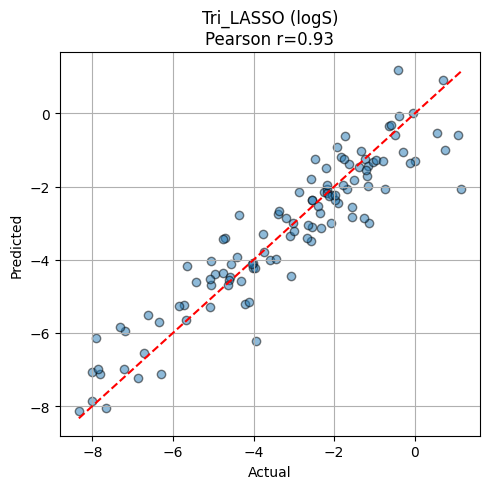


--- Tri_Elastic (logS) ---
RMSE     : 0.9955
MSE      : 0.9911
MAE      : 0.7775
R²       : 0.8104
Pearson r: 0.9051


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+00, tolerance: 8.321e-02
  model = cd_fast.enet_coordinate_descent(


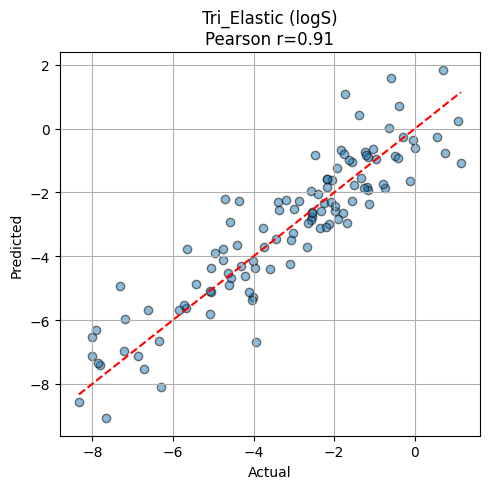


--- Tri_RF (logS) ---
RMSE     : 0.8696
MSE      : 0.7562
MAE      : 0.6944
R²       : 0.8553
Pearson r: 0.9304


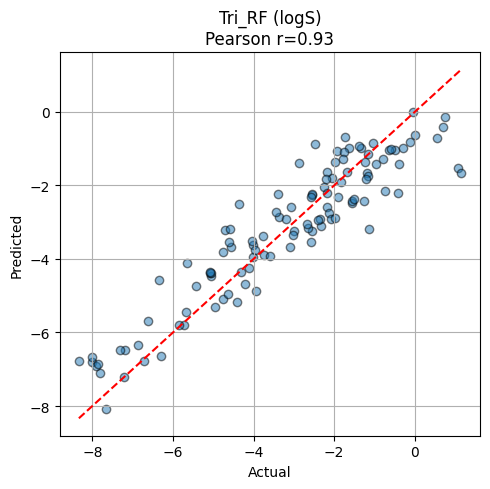


--- Tri_GB (logS) ---
RMSE     : 0.7951
MSE      : 0.6322
MAE      : 0.6016
R²       : 0.8791
Pearson r: 0.9406


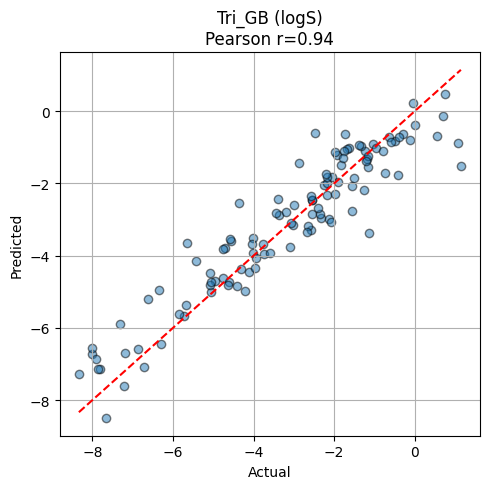


--- Tri_SGD (logS) ---
RMSE     : 0.8709
MSE      : 0.7585
MAE      : 0.6637
R²       : 0.8549
Pearson r: 0.9288


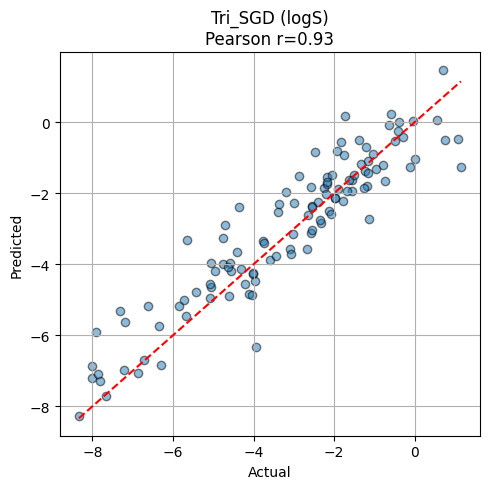


Best Tri-fusion model for logS: Tri_GB with RMSE 0.7951


In [59]:
# === CONFIG ===
tasks = ['logP', 'logS']  # Tri-fusion only
fusion_methods = {
    "Tri_LASSO": Lasso(alpha=0.03, max_iter=10000),
    "Tri_Elastic": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "Tri_RF": RandomForestRegressor(n_estimators=100, random_state=42),
    "Tri_GB": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Tri_SGD": SGDRegressor(loss='squared_error', penalty='l2', max_iter=10000,
                            learning_rate='invscaling', eta0=0.01, random_state=42)
}
# === TRI-FUSION LOOP ===
for task in tasks:
    print(f"\n===== Running Tri-fusion for task: {task} =====")

    # Load features
    t_feat = np.load(f'/kaggle/input/fusion-dataset/transformer_features_{task}.npy')
    b_feat = np.load(f'/kaggle/input/fusion-dataset/bigru_features_{task}.npy')
    g_feat = np.load(f'/kaggle/input/fusion-dataset/gcn_features_{task}.npy')
    y = np.load(f'/kaggle/input/fusion-dataset/targets_{task}.npy').reshape(-1, 1)

    # Combine features
    X = np.concatenate([t_feat, b_feat, g_feat], axis=1)

    # Train-val-test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
    X_train, X_tune, y_train, y_tune = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42)

    best_score = float('inf')
    best_model = None
    best_name = ""

    for name, model in fusion_methods.items():
        model.fit(X_tune, y_tune.ravel())
        preds = model.predict(X_test).flatten()
        rmse = np.sqrt(mean_squared_error(y_test.flatten(), preds))

        evaluate_and_plot(model, X_test, y_test, f'{name} ({task})')

        if rmse < best_score:
            best_score = rmse
            best_model = clone(model)
            best_model.fit(np.concatenate([X_train, X_tune]), np.concatenate([y_train, y_tune]).ravel())
            best_name = name

    print(f"\nBest Tri-fusion model for {task}: {best_name} with RMSE {best_score:.4f}")
    joblib.dump(best_model, f'model_{task}.pkl')


===== Running Tetra-fusion for task: logD =====
[DEBUG] Combined Tetra feature shape: (1130, 1826)
[DEBUG] Train+Val samples: 1017
[DEBUG] Test samples     : 113
[DEBUG] Final Train set  : 813
[DEBUG] Tune set         : 204

--- Tetra_LASSO (logD) ---
RMSE     : 0.8059
MSE      : 0.6495
MAE      : 0.6108
R²       : 0.8247
Pearson r: 0.9110


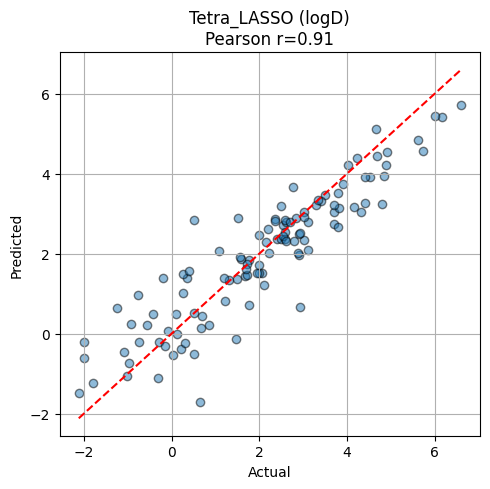


--- Tetra_Elastic (logD) ---
RMSE     : 0.7889
MSE      : 0.6223
MAE      : 0.6179
R²       : 0.8321
Pearson r: 0.9122


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e-01, tolerance: 6.881e-02
  model = cd_fast.enet_coordinate_descent(


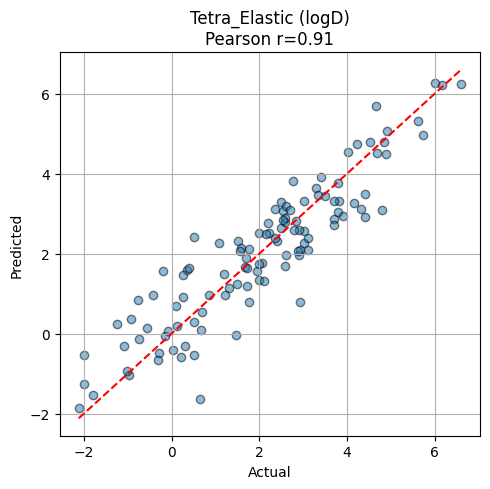

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.543e+00, tolerance: 3.317e-01
  model = cd_fast.enet_coordinate_descent(



--- Tetra_RF (logD) ---
RMSE     : 1.2285
MSE      : 1.5093
MAE      : 0.9198
R²       : 0.5927
Pearson r: 0.7751


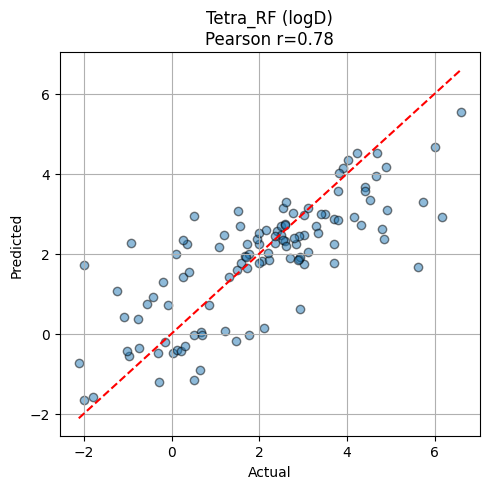


--- Tetra_GB (logD) ---
RMSE     : 1.0796
MSE      : 1.1656
MAE      : 0.7939
R²       : 0.6854
Pearson r: 0.8345


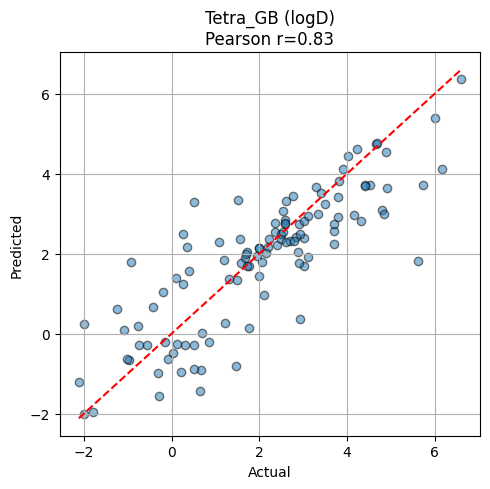


--- Tetra_SGD (logD) ---
RMSE     : 0.7948
MSE      : 0.6318
MAE      : 0.6205
R²       : 0.8295
Pearson r: 0.9118


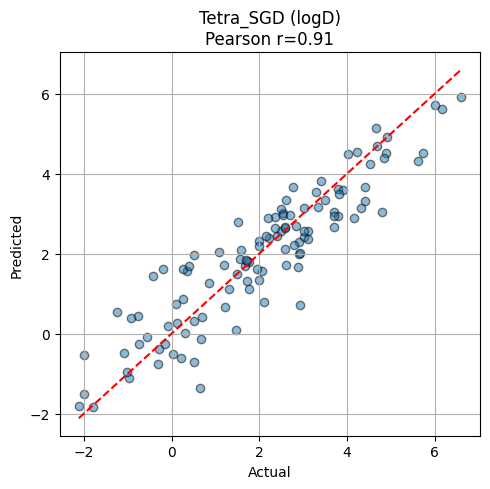


Best Tetra-fusion model for logD: Tetra_Elastic with RMSE 0.7889


['model_logD.pkl']

In [62]:
# === TETRA-FUSION CONFIG (logD only) ===
print(f"\n===== Running Tetra-fusion for task: logD =====")

# Load precomputed features
t_feat = np.load('/kaggle/input/fusion-dataset/transformer_features_logD.npy')
b_feat = np.load('/kaggle/input/fusion-dataset/bigru_features_logD.npy')
g_feat = np.load('/kaggle/input/fusion-dataset/gcn_features_logD.npy')
m_feat = np.load('/kaggle/input/fusion-dataset/mlp_features_logD.npy')  # 3D EC3FP features
y = np.load('/kaggle/input/fusion-dataset/targets_logD.npy').reshape(-1, 1)

# Concatenate all features (Tetra-fusion)
X = np.concatenate([t_feat, b_feat, g_feat, m_feat], axis=1)
print(f"[DEBUG] Combined Tetra feature shape: {X.shape}")

# Train-validation-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_tune, y_train, y_tune = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42)

print(f"[DEBUG] Train+Val samples: {X_trainval.shape[0]}")
print(f"[DEBUG] Test samples     : {X_test.shape[0]}")
print(f"[DEBUG] Final Train set  : {X_train.shape[0]}")
print(f"[DEBUG] Tune set         : {X_tune.shape[0]}")

# Define Tetra-fusion models
fusion_methods_tetra = {
    "Tetra_LASSO": Lasso(alpha=0.03, max_iter=10000),
    "Tetra_Elastic": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "Tetra_RF": RandomForestRegressor(n_estimators=100, random_state=42),
    "Tetra_GB": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Tetra_SGD": SGDRegressor(loss='squared_error', penalty='l2', max_iter=10000, learning_rate='invscaling', eta0=0.01, random_state=42)
}

# Model selection
best_score = float('inf')
best_model = None
best_name = ""

for name, model in fusion_methods_tetra.items():
    model.fit(X_tune, y_tune.ravel())
    preds = model.predict(X_test).flatten()
    score = mean_squared_error(y_test.flatten(), preds) ** 0.5

    evaluate_and_plot(model, X_test, y_test, f'{name} (logD)')

    if score < best_score:
        best_score = score
        best_model = clone(model)
        best_model.fit(np.concatenate([X_train, X_tune]), np.concatenate([y_train, y_tune]).ravel())
        best_name = name

print(f"\nBest Tetra-fusion model for logD: {best_name} with RMSE {best_score:.4f}")
joblib.dump(best_model, 'model_logD.pkl')